In [1]:
# update with no scooters in NY

import pandas as pd
import seaborn as sns
import numpy as np
import linearmodels as lm
import matplotlib
import math
import statsmodels.formula.api as smf
import statsmodels.api as sm

from linearmodels.panel import PanelOLS
from linearmodels.panel import RandomEffects
from linearmodels.panel import FirstDifferenceOLS
from linearmodels.panel import compare
from matplotlib import pyplot as plt

from pandas.api.types import is_numeric_dtype


pd.set_option('display.max_columns', 500)

%matplotlib inline

/Users/rianajawad/anaconda3/lib/python3.7/site-packages/linearmodels/panel/data.py:10: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import (Categorical, DataFrame, Index, MultiIndex, Panel, Series,


In [2]:
df=pd.read_csv('final_estimation_file_apta_added_greg3.csv',
                    encoding='utf-8')
df.drop(columns=['Unnamed: 0'],inplace=True)

In [3]:
df.dtypes

CBSA                    int64
MNAME                  object
Mode                   object
Year                    int64
UPT_ADJUSTED            int64
                       ...   
LRT_ROUTE_MILES       float64
HR_LRT_ROUTE_MILES    float64
HR_EXPANSION            int64
LRT_EXPANSION           int64
ROUTE_MILE_NOTES       object
Length: 101, dtype: object

In [4]:
tsd_data=pd.read_csv('tsd_pop_employment.csv',
                    encoding='utf-8')
tsd_data.drop(columns=['Unnamed: 0','CBSA Title'],inplace=True)
tsd_data = tsd_data.groupby(['CBSA Code','Year']).sum().reset_index()
tsd_data.head()

,CBSA Code,Year,TOTAL_JOBS_WA_TRACTS,JOBS_LESS_THAN_1250_WA_TRACTS,JOBS_1250_3333_WA_TRACTS,JOBS_MORE_THAN_3333_WA_TRACTS,JOBS_WHITE_ALONE_WA_TRACTS,JOBS_BLACK_ALONE_WA_TRACTS,JOBS_HISPANIC_LATINO_WA_TRACTS,JOBS_LESS_THAN_40K_WA_TRACTS,JOBS_NON_WHITE_WA_TRACTS,JOBS_UPTO_HIGH_SCHOOL_WA_TRACTS,JOBS_COLLEGE_OR_HIGHER_WA_TRACTS,TOTAL_JOBS_WA_TSD_TRACTS,JOBS_LESS_THAN_1250_WA_TSD_TRACTS,JOBS_1250_3333_WA_TSD_TRACTS,JOBS_MORE_THAN_3333_WA_TSD_TRACTS,JOBS_WHITE_ALONE_WA_TSD_TRACTS,JOBS_BLACK_ALONE_WA_TSD_TRACTS,JOBS_HISPANIC_LATINO_WA_TSD_TRACTS,JOBS_LESS_THAN_40K_WA_TSD_TRACTS,JOBS_NON_WHITE_WA_TSD_TRACTS,JOBS_UPTO_HIGH_SCHHOL_WA_TSD_TRACTS,JOBS_COLLEGE_OR_HIGHER_WA_TSD_TRACTS,TOTAL_JOBS_RA_TRACTS,TOTAL_JOBS_WHITE_ALONE_RA_TRACTS,TOTAL_JOBS_BLACK_ALONE_RA_TRACTS,TOTAL_JOBS_HISPANIC_LATINO_RA_TRACTS,TOTAL_JOBS_UNDER_1250_RA_TRACTS,TOTAL_JOBS_BETN_1250_3333_RA_TRACTS,TOTAL_JOBS_OVER_3333_RA_TRACTS,TOTAL_JOBS_UNDER_3333_RA_TRACTS,TOTAL_JOBS_NON_WHITE_RA_TRACTS,TOTAL_JOBS_UPTO_HIGH_SCHHOL_RA_TRACTS,TOTAL_JOBS_COLLEGE_OR_HIGHER_RA_TRACTS,AREA_ACRE,TOTAL_JOBS_RA_TSD_TRACTS,TOTAL_JOBS_WHITE_ALONE_RA_TSD_TRACTS,TOTAL_JOBS_BLACK_ALONE_RA_TSD_TRACTS,TOTAL_JOBS_HISPANIC_LATINO_RA_TSD_TRACTS,TOTAL_JOBS_UNDER_1250_RA_TSD_TRACTS,TOTAL_JOBS_BETN_1250_3333_RA_TSD_TRACTS,TOTAL_JOBS_OVER_3333_RA_TSD_TRACTS,TOTAL_JOBS_UNDER_3333_RA_TSD_TRACTS,TOTAL_JOBS_NON_WHITE_RA_TSD_TRACTS,TOTAL_JOBS_UPTO_HIGH_SCHHOL_RA_TSD_TRACTS,TOTAL_JOBS_COLLEGE_OR_HIGHER_RA_TSD_TRACTS
0,10180,2002,57166.0,22735.0,25452.0,8979.0,0.0,0.0,0.0,48187.0,57166.0,0.0,0.0,9489.0,4531.0,3582.0,1376.0,0.0,0.0,0.0,8113.0,9489.0,0.0,0.0,58397.0,0.0,0.0,0.0,23086.0,25800.0,9511.0,48886.0,58397.0,0.0,0.0,1216.0,2355.0,0.0,0.0,0.0,954.0,1065.0,336.0,2019.0,2355.0,0.0,0.0
1,10180,2003,56917.0,21970.0,25046.0,9901.0,0.0,0.0,0.0,47016.0,56917.0,0.0,0.0,9484.0,4402.0,3471.0,1611.0,0.0,0.0,0.0,7873.0,9484.0,0.0,0.0,57221.0,0.0,0.0,0.0,22049.0,25074.0,10098.0,47123.0,57221.0,0.0,0.0,1216.0,2462.0,0.0,0.0,0.0,1032.0,1069.0,361.0,2101.0,2462.0,0.0,0.0
2,10180,2004,59025.0,22123.0,26375.0,10527.0,0.0,0.0,0.0,48498.0,59025.0,0.0,0.0,9599.0,4443.0,3594.0,1562.0,0.0,0.0,0.0,8037.0,9599.0,0.0,0.0,61419.0,0.0,0.0,0.0,23062.0,27199.0,11158.0,50261.0,61419.0,0.0,0.0,1216.0,2970.0,0.0,0.0,0.0,1231.0,1315.0,424.0,2546.0,2970.0,0.0,0.0
3,10180,2005,57879.0,21202.0,25353.0,11324.0,0.0,0.0,0.0,46555.0,57879.0,0.0,0.0,9645.0,4539.0,3500.0,1606.0,0.0,0.0,0.0,8039.0,9645.0,0.0,0.0,60001.0,0.0,0.0,0.0,21854.0,26081.0,12066.0,47935.0,60001.0,0.0,0.0,1216.0,2938.0,0.0,0.0,0.0,1134.0,1326.0,478.0,2460.0,2938.0,0.0,0.0
4,10180,2006,59588.0,21170.0,25759.0,12659.0,0.0,0.0,0.0,46929.0,59588.0,0.0,0.0,9819.0,4475.0,3516.0,1828.0,0.0,0.0,0.0,7991.0,9819.0,0.0,0.0,62311.0,0.0,0.0,0.0,22008.0,26639.0,13664.0,48647.0,62311.0,0.0,0.0,1216.0,2983.0,0.0,0.0,0.0,1122.0,1342.0,519.0,2464.0,2983.0,0.0,0.0


In [5]:
df=pd.merge(df,tsd_data,left_on=['CBSA','Year'],right_on=['CBSA Code','Year'],how='left')
df=df.drop_duplicates()
df.head()

,CBSA,MNAME,Mode,Year,UPT_ADJUSTED,VRM_ADJUSTED,FARE_ADJUSTED,FARE_per_UPT_cleaned,min_year,max_year,FARE_per_UPT,PROBLEM_FLAG,NOTE,PROBLEM_FLAG2,PROBLEM_FLAG3,Tot_Pop,Tot_Instate_Pop,Tot_Outstate_Pop,Tot_NonUSA_POP,Total_Median_Income_Individual,Native_Instate_Med_Inc_Indiv,Native_Outstate_Med_Inc_Indiv,Native_Outcountry_Med_Inc_Indiv,Total_Pop_Poverty,Pop_Below100_Poverty,Pop_Below150_Poverty,Pop_Above150_Poverty,Age_under18,Age_18to64,Age_over64,Total_HH,HH_0Veh,HH_1Veh,HH_2Veh,HH_3Veh,HH_4+Veh,PCT_HH_NO_VEH,HH_MED_INC,HH_MEAN_INC,INC_U35,INC_35_100,INC_100P,TOT_UNEMP_MSA,TOT_EMP_MSA,TOT_LABOR_MSA,UNEMP_RATE_PCT,EMP_RATE_PCT,GasPrice,Area_acre,POP_CENSUSTRACT,AVG_SPEED,2018_Dollar_Multiplier,TNC_ARRIVAL,Link_x,TNC_FLAG,YEARS_SINCE_TNC,FARE_ADJ_2018,TOTAL_MED_INC_INDIV_2018,NATIVE_INSTATE_MED_INC_2018,NATIVE_OUTSTATE_MED_INC_2018,HH_MED_INC_2018,HH_MEAN_INC_2018,GAS_PRICE_2018,dockCt,docklessCt,scooterCt,PBS_Start,PBS_End,PBS_Flag,Link,walkscore,transit,bike,CLUSTER_GT_NEW_11,CLUSTER_GT_ORIGINAL,CLUSTER_GT_8_GROUPS,CLUSTER_APTA,CLUSTER_NOTE,TOTAL_EMPLOYMENT,JTW_DA_PCT,JTW_CARPOOLED_PCT,JTW_TRANSIT_PCT,JTW_WALK_PCT,JTW_BICYCLE_PCT,JTW_OTHER_PCT,JTW_HOME_PCT,NOTE_JTW,AVG_FARE_2018,WEIGHTED_POP_DENSITY,_merge,CLUSTER_APTA_EXTENDED,Manhattan_Pop,Manhattan_Emp,NYC_POP,TTI_CONG_PER_COMMUTER_NY,HR_ROUTE_MILES,LRT_ROUTE_MILES,HR_LRT_ROUTE_MILES,HR_EXPANSION,LRT_EXPANSION,ROUTE_MILE_NOTES,CBSA Code,TOTAL_JOBS_WA_TRACTS,JOBS_LESS_THAN_1250_WA_TRACTS,JOBS_1250_3333_WA_TRACTS,JOBS_MORE_THAN_3333_WA_TRACTS,JOBS_WHITE_ALONE_WA_TRACTS,JOBS_BLACK_ALONE_WA_TRACTS,JOBS_HISPANIC_LATINO_WA_TRACTS,JOBS_LESS_THAN_40K_WA_TRACTS,JOBS_NON_WHITE_WA_TRACTS,JOBS_UPTO_HIGH_SCHOOL_WA_TRACTS,JOBS_COLLEGE_OR_HIGHER_WA_TRACTS,TOTAL_JOBS_WA_TSD_TRACTS,JOBS_LESS_THAN_1250_WA_TSD_TRACTS,JOBS_1250_3333_WA_TSD_TRACTS,JOBS_MORE_THAN_3333_WA_TSD_TRACTS,JOBS_WHITE_ALONE_WA_TSD_TRACTS,JOBS_BLACK_ALONE_WA_TSD_TRACTS,JOBS_HISPANIC_LATINO_WA_TSD_TRACTS,JOBS_LESS_THAN_40K_WA_TSD_TRACTS,JOBS_NON_WHITE_WA_TSD_TRACTS,JOBS_UPTO_HIGH_SCHHOL_WA_TSD_TRACTS,JOBS_COLLEGE_OR_HIGHER_WA_TSD_TRACTS,TOTAL_JOBS_RA_TRACTS,TOTAL_JOBS_WHITE_ALONE_RA_TRACTS,TOTAL_JOBS_BLACK_ALONE_RA_TRACTS,TOTAL_JOBS_HISPANIC_LATINO_RA_TRACTS,TOTAL_JOBS_UNDER_1250_RA_TRACTS,TOTAL_JOBS_BETN_1250_3333_RA_TRACTS,TOTAL_JOBS_OVER_3333_RA_TRACTS,TOTAL_JOBS_UNDER_3333_RA_TRACTS,TOTAL_JOBS_NON_WHITE_RA_TRACTS,TOTAL_JOBS_UPTO_HIGH_SCHHOL_RA_TRACTS,TOTAL_JOBS_COLLEGE_OR_HIGHER_RA_TRACTS,AREA_ACRE,TOTAL_JOBS_RA_TSD_TRACTS,TOTAL_JOBS_WHITE_ALONE_RA_TSD_TRACTS,TOTAL_JOBS_BLACK_ALONE_RA_TSD_TRACTS,TOTAL_JOBS_HISPANIC_LATINO_RA_TSD_TRACTS,TOTAL_JOBS_UNDER_1250_RA_TSD_TRACTS,TOTAL_JOBS_BETN_1250_3333_RA_TSD_TRACTS,TOTAL_JOBS_OVER_3333_RA_TSD_TRACTS,TOTAL_JOBS_UNDER_3333_RA_TSD_TRACTS,TOTAL_JOBS_NON_WHITE_RA_TSD_TRACTS,TOTAL_JOBS_UPTO_HIGH_SCHHOL_RA_TSD_TRACTS,TOTAL_JOBS_COLLEGE_OR_HIGHER_RA_TSD_TRACTS
0,10420,"Akron, OH Metro Area",Bus,2002,5226386,4026372,596583,0.114148,2002,2018,0.114148,NaN,Bad fare,NaN,1.0,646583.7344,496141.0469,137193.6719,-389.53125,25405.20313,26028.32813,26651.07813,7117.03125,682354.11,7.55,8.94,83.85,24.64,62.9,12.46,265452.20,22830.14,58254.52,117083.25,46891.53,20392.77,8.60,43046.82813,55300.5625,39.49,46.56,13.95,21948.42,346147.17,368095.58,5.96,94.04,1.36,NaN,119786.0,14.88,1.40,2014,http://www.crainscleveland.com/article/2014082...,0,0,4004892.28,35567.28438,36439.65938,37311.50938,60265.55938,77420.7875,1.9040,0,0,0,NaN,NaN,0.0,NaN,0,0,0,1,1,H,24,NaN,309488.2031,87.4,6.2,0.8,1.7,0.1,0.7,3.1,Goes to negative when extrapolating. Possible ...,0.159808,2417.239652,both,24,0,0,0,0.0,0.0,0.0,0.0,0,0,NaN,10420.0,314749.0,96006.0,131687.0,87056.0,0.0,0.0,0.0,227693.0,314749.0,0.0,0.0,81463.0,23319.0,33326.0,24818.0,0.0,0.0,0.0,56645.0,81463.0,0.0,0.0,305401.0,0.0,0.0,0.0,92556.0,127165.0,85680.0,219721.0,305401.0,0.0,0.0,13619.2,54517.0,0.0,0.0,0.0,18228.0,25397.0,10892.0,43625.0,54517.0,0.0,0.0
1,10420,"Akron, OH Metro Area",Bus,2003,5395902,3976569,2318587,0.429694,2002,2018,0.429694,NaN,Na

In [6]:
# merge TTI Congestion data
tti_data=pd.read_csv('CBSA_TTI_DELAY.csv',encoding='utf-8')
tti_data.drop(columns=['MNAME'],inplace=True)
df=pd.merge(df,tti_data,left_on=['CBSA','Year'],right_on=['CBSA','Year'],how='left')

In [7]:
df.head()

,CBSA,MNAME,Mode,Year,UPT_ADJUSTED,VRM_ADJUSTED,FARE_ADJUSTED,FARE_per_UPT_cleaned,min_year,max_year,FARE_per_UPT,PROBLEM_FLAG,NOTE,PROBLEM_FLAG2,PROBLEM_FLAG3,Tot_Pop,Tot_Instate_Pop,Tot_Outstate_Pop,Tot_NonUSA_POP,Total_Median_Income_Individual,Native_Instate_Med_Inc_Indiv,Native_Outstate_Med_Inc_Indiv,Native_Outcountry_Med_Inc_Indiv,Total_Pop_Poverty,Pop_Below100_Poverty,Pop_Below150_Poverty,Pop_Above150_Poverty,Age_under18,Age_18to64,Age_over64,Total_HH,HH_0Veh,HH_1Veh,HH_2Veh,HH_3Veh,HH_4+Veh,PCT_HH_NO_VEH,HH_MED_INC,HH_MEAN_INC,INC_U35,INC_35_100,INC_100P,TOT_UNEMP_MSA,TOT_EMP_MSA,TOT_LABOR_MSA,UNEMP_RATE_PCT,EMP_RATE_PCT,GasPrice,Area_acre,POP_CENSUSTRACT,AVG_SPEED,2018_Dollar_Multiplier,TNC_ARRIVAL,Link_x,TNC_FLAG,YEARS_SINCE_TNC,FARE_ADJ_2018,TOTAL_MED_INC_INDIV_2018,NATIVE_INSTATE_MED_INC_2018,NATIVE_OUTSTATE_MED_INC_2018,HH_MED_INC_2018,HH_MEAN_INC_2018,GAS_PRICE_2018,dockCt,docklessCt,scooterCt,PBS_Start,PBS_End,PBS_Flag,Link,walkscore,transit,bike,CLUSTER_GT_NEW_11,CLUSTER_GT_ORIGINAL,CLUSTER_GT_8_GROUPS,CLUSTER_APTA,CLUSTER_NOTE,TOTAL_EMPLOYMENT,JTW_DA_PCT,JTW_CARPOOLED_PCT,JTW_TRANSIT_PCT,JTW_WALK_PCT,JTW_BICYCLE_PCT,JTW_OTHER_PCT,JTW_HOME_PCT,NOTE_JTW,AVG_FARE_2018,WEIGHTED_POP_DENSITY,_merge,CLUSTER_APTA_EXTENDED,Manhattan_Pop,Manhattan_Emp,NYC_POP,TTI_CONG_PER_COMMUTER_NY,HR_ROUTE_MILES,LRT_ROUTE_MILES,HR_LRT_ROUTE_MILES,HR_EXPANSION,LRT_EXPANSION,ROUTE_MILE_NOTES,CBSA Code,TOTAL_JOBS_WA_TRACTS,JOBS_LESS_THAN_1250_WA_TRACTS,JOBS_1250_3333_WA_TRACTS,JOBS_MORE_THAN_3333_WA_TRACTS,JOBS_WHITE_ALONE_WA_TRACTS,JOBS_BLACK_ALONE_WA_TRACTS,JOBS_HISPANIC_LATINO_WA_TRACTS,JOBS_LESS_THAN_40K_WA_TRACTS,JOBS_NON_WHITE_WA_TRACTS,JOBS_UPTO_HIGH_SCHOOL_WA_TRACTS,JOBS_COLLEGE_OR_HIGHER_WA_TRACTS,TOTAL_JOBS_WA_TSD_TRACTS,JOBS_LESS_THAN_1250_WA_TSD_TRACTS,JOBS_1250_3333_WA_TSD_TRACTS,JOBS_MORE_THAN_3333_WA_TSD_TRACTS,JOBS_WHITE_ALONE_WA_TSD_TRACTS,JOBS_BLACK_ALONE_WA_TSD_TRACTS,JOBS_HISPANIC_LATINO_WA_TSD_TRACTS,JOBS_LESS_THAN_40K_WA_TSD_TRACTS,JOBS_NON_WHITE_WA_TSD_TRACTS,JOBS_UPTO_HIGH_SCHHOL_WA_TSD_TRACTS,JOBS_COLLEGE_OR_HIGHER_WA_TSD_TRACTS,TOTAL_JOBS_RA_TRACTS,TOTAL_JOBS_WHITE_ALONE_RA_TRACTS,TOTAL_JOBS_BLACK_ALONE_RA_TRACTS,TOTAL_JOBS_HISPANIC_LATINO_RA_TRACTS,TOTAL_JOBS_UNDER_1250_RA_TRACTS,TOTAL_JOBS_BETN_1250_3333_RA_TRACTS,TOTAL_JOBS_OVER_3333_RA_TRACTS,TOTAL_JOBS_UNDER_3333_RA_TRACTS,TOTAL_JOBS_NON_WHITE_RA_TRACTS,TOTAL_JOBS_UPTO_HIGH_SCHHOL_RA_TRACTS,TOTAL_JOBS_COLLEGE_OR_HIGHER_RA_TRACTS,AREA_ACRE,TOTAL_JOBS_RA_TSD_TRACTS,TOTAL_JOBS_WHITE_ALONE_RA_TSD_TRACTS,TOTAL_JOBS_BLACK_ALONE_RA_TSD_TRACTS,TOTAL_JOBS_HISPANIC_LATINO_RA_TSD_TRACTS,TOTAL_JOBS_UNDER_1250_RA_TSD_TRACTS,TOTAL_JOBS_BETN_1250_3333_RA_TSD_TRACTS,TOTAL_JOBS_OVER_3333_RA_TSD_TRACTS,TOTAL_JOBS_UNDER_3333_RA_TSD_TRACTS,TOTAL_JOBS_NON_WHITE_RA_TSD_TRACTS,TOTAL_JOBS_UPTO_HIGH_SCHHOL_RA_TSD_TRACTS,TOTAL_JOBS_COLLEGE_OR_HIGHER_RA_TSD_TRACTS,Unnamed: 0,TTI_INTERPOLATION,TTI,DEL_PER_AUTO_COMMUTER,TOT_DELAY_HRS
0,10420,"Akron, OH Metro Area",Bus,2002,5226386,4026372,596583,0.114148,2002,2018,0.114148,NaN,Bad fare,NaN,1.0,646583.7344,496141.0469,137193.6719,-389.53125,25405.20313,26028.32813,26651.07813,7117.03125,682354.11,7.55,8.94,83.85,24.64,62.9,12.46,265452.20,22830.14,58254.52,117083.25,46891.53,20392.77,8.60,43046.82813,55300.5625,39.49,46.56,13.95,21948.42,346147.17,368095.58,5.96,94.04,1.36,NaN,119786.0,14.88,1.40,2014,http://www.crainscleveland.com/article/2014082...,0,0,4004892.28,35567.28438,36439.65938,37311.50938,60265.55938,77420.7875,1.9040,0,0,0,NaN,NaN,0.0,NaN,0,0,0,1,1,H,24,NaN,309488.2031,87.4,6.2,0.8,1.7,0.1,0.7,3.1,Goes to negative when extrapolating. Possible ...,0.159808,2417.239652,both,24,0,0,0,0.0,0.0,0.0,0.0,0,0,NaN,10420.0,314749.0,96006.0,131687.0,87056.0,0.0,0.0,0.0,227693.0,314749.0,0.0,0.0,81463.0,23319.0,33326.0,24818.0,0.0,0.0,0.0,56645.0,81463.0,0.0,0.0,305401.0,0.0,0.0,0.0,92556.0,127165.0,85680.0,219721.0,305401.0,0.0,0.0,13619.2,54517.0,0.0,0.0,0.0,18228.0,25397.0,10892.0,43625.0,54517.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN
1,10420,"

In [8]:
# WAC data derived columns. To account for people coming into the TSD from outlying areas.
df['TSD_WA_EMP_PCT_LEHD']=100*df['TOTAL_JOBS_WA_TSD_TRACTS']/df['TOTAL_JOBS_WA_TRACTS']
df['TSD_WA_EMP_PCT_CBSA']=100*df['TOTAL_JOBS_WA_TSD_TRACTS']/df['TOT_EMP_MSA']

df['JOBS_LESS_THAN_3333_WA_TRACTS']=df['JOBS_LESS_THAN_1250_WA_TRACTS']+df['JOBS_1250_3333_WA_TRACTS']
df['JOBS_LESS_THAN_3333_WA_TSD_TRACTS']=df['JOBS_LESS_THAN_1250_WA_TSD_TRACTS']+df['JOBS_1250_3333_WA_TSD_TRACTS']

df['TSD_WA_EMP_WAGE_UNDER_1250']=100*df['JOBS_LESS_THAN_1250_WA_TSD_TRACTS']/df['TOTAL_JOBS_WA_TRACTS']
df['TSD_WA_EMP_WAGE_BETN_1250_3333']=100*df['JOBS_1250_3333_WA_TSD_TRACTS']/df['TOTAL_JOBS_WA_TRACTS']
df['TSD_WA_EMP_WAGE_UNDER_3333']=100*df['JOBS_LESS_THAN_3333_WA_TSD_TRACTS']/df['TOTAL_JOBS_WA_TRACTS']

df['TSD_WA_EMP_WAGE_UNDER_1250_PCT_WA']=100*df['JOBS_LESS_THAN_1250_WA_TSD_TRACTS']/df['JOBS_LESS_THAN_1250_WA_TRACTS']
df['TSD_WA_EMP_WAGE_BETN_1250_3333_PCT_WA']=100*df['JOBS_1250_3333_WA_TSD_TRACTS']/df['JOBS_1250_3333_WA_TRACTS']
df['TSD_WA_EMP_WAGE_UNDER_3333_PCT_WA']=100*df['JOBS_LESS_THAN_3333_WA_TSD_TRACTS']/df['JOBS_LESS_THAN_3333_WA_TRACTS']

df['TSD_WA_EMP_WAGE_UNDER_1250_PCT_TSD']=100*df['JOBS_LESS_THAN_1250_WA_TSD_TRACTS']/df['TOTAL_JOBS_WA_TSD_TRACTS']
df['TSD_WA_EMP_WAGE_BETN_1250_3333_PCT_TSD']=100*df['JOBS_1250_3333_WA_TSD_TRACTS']/df['TOTAL_JOBS_WA_TSD_TRACTS']
df['TSD_WA_EMP_WAGE_UNDER_3333_PCT_TSD']=100*df['JOBS_LESS_THAN_3333_WA_TSD_TRACTS']/df['TOTAL_JOBS_WA_TSD_TRACTS']

#RAC data derived columns.

df['TSD_POP_PCT_LEHD']=100*df['TOTAL_JOBS_RA_TSD_TRACTS']/df['TOTAL_JOBS_RA_TRACTS'] #RAC data
df['TSD_POP_PCT_CBSA']=100*df['TOTAL_JOBS_RA_TSD_TRACTS']/df['Tot_Pop']
df['TSD_POP_WAGE_UNDER_1250']=100*df['TOTAL_JOBS_UNDER_1250_RA_TSD_TRACTS']/df['TOTAL_JOBS_RA_TRACTS']
df['TSD_POP_WAGE_BETN_1250_3333']=100*df['TOTAL_JOBS_BETN_1250_3333_RA_TSD_TRACTS']/df['TOTAL_JOBS_RA_TRACTS']
df['TSD_POP_WAGE_UNDER_3333']=100*df['TOTAL_JOBS_UNDER_3333_RA_TSD_TRACTS']/df['TOTAL_JOBS_RA_TRACTS']

df['TSD_POP_WAGE_UNDER_1250_PCT_RA']=100*df['TOTAL_JOBS_UNDER_1250_RA_TSD_TRACTS']/df['TOTAL_JOBS_UNDER_1250_RA_TRACTS']
df['TSD_POP_WAGE_BETN_1250_3333_PCT_RA']=100*df['TOTAL_JOBS_BETN_1250_3333_RA_TSD_TRACTS']/df['TOTAL_JOBS_BETN_1250_3333_RA_TRACTS']
df['TSD_POP_WAGE_UNDER_3333_PCT_RA']=100*df['TOTAL_JOBS_UNDER_3333_RA_TSD_TRACTS']/df['TOTAL_JOBS_UNDER_3333_RA_TRACTS']

df['TSD_POP_WAGE_UNDER_1250_PCT_TSD']=100*df['TOTAL_JOBS_UNDER_1250_RA_TSD_TRACTS']/df['TOTAL_JOBS_RA_TSD_TRACTS']
df['TSD_POP_WAGE_BETN_1250_3333_PCT_TSD']=100*df['TOTAL_JOBS_BETN_1250_3333_RA_TSD_TRACTS']/df['TOTAL_JOBS_RA_TSD_TRACTS']
df['TSD_POP_WAGE_UNDER_3333_PCT_TSD']=100*df['TOTAL_JOBS_UNDER_3333_RA_TSD_TRACTS']/df['TOTAL_JOBS_RA_TSD_TRACTS']


In [9]:
# read updated TNC revenue data
# tnc_rev=pd.read_csv('TNC_REVENUE_3.csv')
# tnc_rev.drop(columns=['Unnamed: 0'],inplace=True)
# tnc_rev=tnc_rev.drop_duplicates(['CBSA','MNAME','Year'])
# tnc_rev.head()

tnc_rev=pd.read_csv('TNC_CBSA_FINAL_2.csv')

tnc_rev.drop(columns=['MNAME','Tot_Pop'],inplace=True)
# tnc_rev=tnc_rev.drop_duplicates(['CBSA','MNAME','Year'])
tnc_rev.head()

,CBSA,Year,TNC_CLUSTER,TOT_POP_CLUSTER,TOTAL_YEARLY_POPULATION,POP_SHARE,TOTAL_TRIPS_PER_CAPITA,TNC_TRIPS_SCALED,TOTAL_TNC_TRIPS_PER_CLUSTER,TRIPS_SCALED,Scale_2,TNC_TRIPS,TNC_TRIPS_PER_CAPITA_CLUSTER
0,10420,2014,21,20063673.0,119360751,0.035997,4.034635,0.9718,80.9496,19.497887,0.514568,10.0,0.5
1,10740,2014,21,20063673.0,119360751,0.035997,4.034635,0.9718,80.9496,19.497887,0.514568,10.0,0.5
2,10900,2014,21,20063673.0,119360751,0.035997,4.034635,0.9718,80.9496,19.497887,0.514568,10.0,0.5
3,11460,2014,21,20063673.0,119360751,0.035997,4.034635,0.9718,80.9496,19.497887,0.514568,10.0,0.5
4,12420,2014,21,20063673.0,119360751,0.035997,4.034635,0.9718,80.9496,19.497887,0.514568,10.0,0.5


In [10]:
df=pd.merge(df,tnc_rev,on=['CBSA','Year'],how='left')
df['TNC_TRIPS_PER_CAPITA_CLUSTER']=df['TNC_TRIPS_PER_CAPITA_CLUSTER'].fillna(0)
df.head()

,CBSA,MNAME,Mode,Year,UPT_ADJUSTED,VRM_ADJUSTED,FARE_ADJUSTED,FARE_per_UPT_cleaned,min_year,max_year,FARE_per_UPT,PROBLEM_FLAG,NOTE,PROBLEM_FLAG2,PROBLEM_FLAG3,Tot_Pop,Tot_Instate_Pop,Tot_Outstate_Pop,Tot_NonUSA_POP,Total_Median_Income_Individual,Native_Instate_Med_Inc_Indiv,Native_Outstate_Med_Inc_Indiv,Native_Outcountry_Med_Inc_Indiv,Total_Pop_Poverty,Pop_Below100_Poverty,Pop_Below150_Poverty,Pop_Above150_Poverty,Age_under18,Age_18to64,Age_over64,Total_HH,HH_0Veh,HH_1Veh,HH_2Veh,HH_3Veh,HH_4+Veh,PCT_HH_NO_VEH,HH_MED_INC,HH_MEAN_INC,INC_U35,INC_35_100,INC_100P,TOT_UNEMP_MSA,TOT_EMP_MSA,TOT_LABOR_MSA,UNEMP_RATE_PCT,EMP_RATE_PCT,GasPrice,Area_acre,POP_CENSUSTRACT,AVG_SPEED,2018_Dollar_Multiplier,TNC_ARRIVAL,Link_x,TNC_FLAG,YEARS_SINCE_TNC,FARE_ADJ_2018,TOTAL_MED_INC_INDIV_2018,NATIVE_INSTATE_MED_INC_2018,NATIVE_OUTSTATE_MED_INC_2018,HH_MED_INC_2018,HH_MEAN_INC_2018,GAS_PRICE_2018,dockCt,docklessCt,scooterCt,PBS_Start,PBS_End,PBS_Flag,Link,walkscore,transit,bike,CLUSTER_GT_NEW_11,CLUSTER_GT_ORIGINAL,CLUSTER_GT_8_GROUPS,CLUSTER_APTA,CLUSTER_NOTE,TOTAL_EMPLOYMENT,JTW_DA_PCT,JTW_CARPOOLED_PCT,JTW_TRANSIT_PCT,JTW_WALK_PCT,JTW_BICYCLE_PCT,JTW_OTHER_PCT,JTW_HOME_PCT,NOTE_JTW,AVG_FARE_2018,WEIGHTED_POP_DENSITY,_merge,CLUSTER_APTA_EXTENDED,Manhattan_Pop,Manhattan_Emp,NYC_POP,TTI_CONG_PER_COMMUTER_NY,HR_ROUTE_MILES,LRT_ROUTE_MILES,HR_LRT_ROUTE_MILES,HR_EXPANSION,LRT_EXPANSION,ROUTE_MILE_NOTES,CBSA Code,TOTAL_JOBS_WA_TRACTS,JOBS_LESS_THAN_1250_WA_TRACTS,JOBS_1250_3333_WA_TRACTS,JOBS_MORE_THAN_3333_WA_TRACTS,JOBS_WHITE_ALONE_WA_TRACTS,JOBS_BLACK_ALONE_WA_TRACTS,JOBS_HISPANIC_LATINO_WA_TRACTS,JOBS_LESS_THAN_40K_WA_TRACTS,JOBS_NON_WHITE_WA_TRACTS,JOBS_UPTO_HIGH_SCHOOL_WA_TRACTS,JOBS_COLLEGE_OR_HIGHER_WA_TRACTS,TOTAL_JOBS_WA_TSD_TRACTS,JOBS_LESS_THAN_1250_WA_TSD_TRACTS,JOBS_1250_3333_WA_TSD_TRACTS,JOBS_MORE_THAN_3333_WA_TSD_TRACTS,JOBS_WHITE_ALONE_WA_TSD_TRACTS,JOBS_BLACK_ALONE_WA_TSD_TRACTS,JOBS_HISPANIC_LATINO_WA_TSD_TRACTS,JOBS_LESS_THAN_40K_WA_TSD_TRACTS,JOBS_NON_WHITE_WA_TSD_TRACTS,JOBS_UPTO_HIGH_SCHHOL_WA_TSD_TRACTS,JOBS_COLLEGE_OR_HIGHER_WA_TSD_TRACTS,TOTAL_JOBS_RA_TRACTS,TOTAL_JOBS_WHITE_ALONE_RA_TRACTS,TOTAL_JOBS_BLACK_ALONE_RA_TRACTS,TOTAL_JOBS_HISPANIC_LATINO_RA_TRACTS,TOTAL_JOBS_UNDER_1250_RA_TRACTS,TOTAL_JOBS_BETN_1250_3333_RA_TRACTS,TOTAL_JOBS_OVER_3333_RA_TRACTS,TOTAL_JOBS_UNDER_3333_RA_TRACTS,TOTAL_JOBS_NON_WHITE_RA_TRACTS,TOTAL_JOBS_UPTO_HIGH_SCHHOL_RA_TRACTS,TOTAL_JOBS_COLLEGE_OR_HIGHER_RA_TRACTS,AREA_ACRE,TOTAL_JOBS_RA_TSD_TRACTS,TOTAL_JOBS_WHITE_ALONE_RA_TSD_TRACTS,TOTAL_JOBS_BLACK_ALONE_RA_TSD_TRACTS,TOTAL_JOBS_HISPANIC_LATINO_RA_TSD_TRACTS,TOTAL_JOBS_UNDER_1250_RA_TSD_TRACTS,TOTAL_JOBS_BETN_1250_3333_RA_TSD_TRACTS,TOTAL_JOBS_OVER_3333_RA_TSD_TRACTS,TOTAL_JOBS_UNDER_3333_RA_TSD_TRACTS,TOTAL_JOBS_NON_WHITE_RA_TSD_TRACTS,TOTAL_JOBS_UPTO_HIGH_SCHHOL_RA_TSD_TRACTS,TOTAL_JOBS_COLLEGE_OR_HIGHER_RA_TSD_TRACTS,Unnamed: 0,TTI_INTERPOLATION,TTI,DEL_PER_AUTO_COMMUTER,TOT_DELAY_HRS,TSD_WA_EMP_PCT_LEHD,TSD_WA_EMP_PCT_CBSA,JOBS_LESS_THAN_3333_WA_TRACTS,JOBS_LESS_THAN_3333_WA_TSD_TRACTS,TSD_WA_EMP_WAGE_UNDER_1250,TSD_WA_EMP_WAGE_BETN_1250_3333,TSD_WA_EMP_WAGE_UNDER_3333,TSD_WA_EMP_WAGE_UNDER_1250_PCT_WA,TSD_WA_EMP_WAGE_BETN_1250_3333_PCT_WA,TSD_WA_EMP_WAGE_UNDER_3333_PCT_WA,TSD_WA_EMP_WAGE_UNDER_1250_PCT_TSD,TSD_WA_EMP_WAGE_BETN_1250_3333_PCT_TSD,TSD_WA_EMP_WAGE_UNDER_3333_PCT_TSD,TSD_POP_PCT_LEHD,TSD_POP_PCT_CBSA,TSD_POP_WAGE_UNDER_1250,TSD_POP_WAGE_BETN_1250_3333,TSD_POP_WAGE_UNDER_3333,TSD_POP_WAGE_UNDER_1250_PCT_RA,TSD_POP_WAGE_BETN_1250_3333_PCT_RA,TSD_POP_WAGE_UNDER_3333_PCT_RA,TSD_POP_WAGE_UNDER_1250_PCT_TSD,TSD_POP_WAGE_BETN_1250_3333_PCT_TSD,TSD_POP_WAGE_UNDER_3333_PCT_TSD,TNC_CLUSTER,TOT_POP_CLUSTER,TOTAL_YEARLY_POPULATION,POP_SHARE,TOTAL_TRIPS_PER_CAPITA,TNC_TRIPS_SCALED,TOTAL_TNC_TRIPS_PER_CLUSTER,TRIPS_SCALED,Scale_2,TNC_TRIPS,TNC_TRIPS_PER_CAPITA_CLUSTER
0,10420,"Akron, OH Metro Area",Bus,2002,5226386,4026372,596583,0.114148,2002,2018,0.114148,NaN,Bad fare,NaN,1.0,646583.7344,496141.0469,137193.6719,-389.53125,25405.20313,

In [11]:
df['TNC_TRIPS_PER_CAPITA_CLUSTER']=df['TNC_TRIPS_PER_CAPITA_CLUSTER'].astype(float)
df['TNC_TRIPS_PER_CAPITA_CLUSTER'].describe()

count    4244.000000
mean        0.714656
std         1.857022
min         0.000000
25%         0.000000
50%         0.000000
75%         0.700000
max        30.400000
Name: TNC_TRIPS_PER_CAPITA_CLUSTER, dtype: float64

In [12]:
# read in and join the maintenance and restructure data
mr=pd.read_csv('maintenance_restructure.csv',
                    encoding='utf-8')
mr = mr[['CBSA', 'Mode', 'Year', 'MAINTENANCE', 'MAINTENANCE_NYC', 'MAINTENANCE_WMATA', 'RESTRUCTURE']]

df = df.merge(mr, on=['CBSA', 'Mode', 'Year'], how='left')

In [13]:
len(df)

4244

In [14]:
# read in mechanical and other failures

failures=pd.read_csv('maintenance_final_greg.csv',encoding='utf-8')
failures.drop(columns=['Unnamed: 0'],inplace=True)

failures = failures.groupby(['CBSA','MNAME','Mode','Year']).sum().reset_index()

In [15]:
df=df.merge(failures, on=['CBSA','MNAME','Mode','Year'],how='left')
df=df.rename(columns={'UPT_ADJUSTED':'UPT_ADJ','VRM_ADJUSTED':'VRM_ADJ','FARE_ADJUSTED':'FARE_ADJ','AVG_FARE_2018':'FARE_per_UPT_2018',
                     'Mecha_Failures':'Mechanical_Failures'})

In [16]:
df['Mechanical_Failures']=df['Mechanical_Failures'].fillna(0)
df['Total_Failures']=df['Total_Failures'].fillna(0)
df['MDBF_Mechanical']=np.where(df['Mechanical_Failures']>0,df['VRM_ADJ']/df['Mechanical_Failures'],df['VRM_ADJ'])
df['MDBF_Total']=np.where(df['Total_Failures']>0,df['VRM_ADJ']/df['Total_Failures'],df['VRM_ADJ'])

In [17]:
# read in and join the bike share updates
bsu=pd.read_csv('bike_share_update.csv',
                    encoding='utf-8')
bsu = bsu[['CBSA', 'Mode', 'Year', 'PBS_Flag_Update']]

df = df.merge(bsu, on=['CBSA', 'Mode', 'Year'], how='left')

#df['PBS_Flag_Missing'] = df['PBS_Flag'].apply(lambda x : x.isnan())
df['PBS_Flag'] = np.where(df['PBS_Flag'].isnull(), df['PBS_Flag_Update'], df['PBS_Flag'])

In [18]:
# 4 apta clusers
df['CLUSTER_APTA4'] = np.floor(df['CLUSTER_APTA']/10)

In [19]:
# exclude if ridership is zero--missing data
df = df[df['UPT_ADJ']>0]

In [20]:
# fill in missing data as needed

# min fare is zero
df['FARE_per_UPT_2018'] = df['FARE_per_UPT_2018'].apply(lambda x : max(x,0))

# max fare is $20
df['FARE_per_UPT_2018'] = df['FARE_per_UPT_2018'].apply(lambda x : min(x,20))

# zero vehicle HH can't go negative
df['HH_0Veh'] = df['HH_0Veh'].apply(lambda x : max(x,0))

In [21]:
df=df.drop_duplicates(['CBSA','Mode','Year'])

In [22]:
# convert JTW to numeric columns
df['JTW_DA_PCT']        = df['JTW_DA_PCT'].replace('#VALUE!', np.nan)
df['JTW_CARPOOLED_PCT'] = df['JTW_CARPOOLED_PCT'].replace('#VALUE!', np.nan)
df['JTW_TRANSIT_PCT']   = df['JTW_TRANSIT_PCT'].replace('#VALUE!', np.nan)
df['JTW_WALK_PCT']      = df['JTW_WALK_PCT'].replace('#VALUE!', np.nan)
df['JTW_BICYCLE_PCT']   = df['JTW_BICYCLE_PCT'].replace('#VALUE!', np.nan)
df['JTW_OTHER_PCT']     = df['JTW_OTHER_PCT'].replace('#VALUE!', np.nan)
df['JTW_HOME_PCT']      = df['JTW_HOME_PCT'].replace('#VALUE!', np.nan)


df['JTW_DA_PCT']        = df['JTW_DA_PCT'].replace('N', np.nan)
df['JTW_CARPOOLED_PCT'] = df['JTW_CARPOOLED_PCT'].replace('N', np.nan)
df['JTW_TRANSIT_PCT']   = df['JTW_TRANSIT_PCT'].replace('N', np.nan)
df['JTW_WALK_PCT']      = df['JTW_WALK_PCT'].replace('N', np.nan)
df['JTW_BICYCLE_PCT']   = df['JTW_BICYCLE_PCT'].replace('N', np.nan)
df['JTW_OTHER_PCT']     = df['JTW_OTHER_PCT'].replace('N', np.nan)
df['JTW_HOME_PCT']      = df['JTW_HOME_PCT'].replace('N', np.nan)



In [23]:
# convert JTW to numeric columns
df['JTW_DA_PCT']        = df['JTW_DA_PCT'].astype(float)
df['JTW_CARPOOLED_PCT'] = df['JTW_CARPOOLED_PCT'].astype(float)
df['JTW_TRANSIT_PCT']   = df['JTW_TRANSIT_PCT'].astype(float)
df['JTW_WALK_PCT']      = df['JTW_WALK_PCT'].astype(float)
df['JTW_BICYCLE_PCT']   = df['JTW_BICYCLE_PCT'].astype(float)
df['JTW_OTHER_PCT']     = df['JTW_OTHER_PCT'].astype(float)
df['JTW_HOME_PCT']      = df['JTW_HOME_PCT'].astype(float)

In [24]:
# exclude problematic data
old_len = len(df)
df = df[df['VRM_ADJ']>0]
new_len = len(df)
print('Excluding ' + str(old_len-new_len) + ' records with missing VRM') 

# exclude if JTW data are missing
old_len = len(df)
df = df[df['JTW_HOME_PCT']>=0]
new_len = len(df)
print('Excluding ' + str(old_len-new_len) + ' records with missing JTW data') 

# exclude if problem flag 3 is set
old_len = len(df)
df = df[df['PROBLEM_FLAG3']!=1]
new_len = len(df)
print('Excluding ' + str(old_len-new_len) + ' records with problem flag set to 1') 

# exclude rail in low op-ex group
old_len = len(df)
df['LOW_OPEX'] = np.where(df['CLUSTER_APTA4']==3, 1, 0)
df['RAIL_FLAG'] = np.where(df['Mode']=='Rail', 1, 0)
df['LOW_OPEX_RAIL'] = df['LOW_OPEX'] * df['RAIL_FLAG']
df = df[df['LOW_OPEX_RAIL']==0]
new_len = len(df)
print('Excluding ' + str(old_len-new_len) + ' records with that have rail in the low op-ex group') 

# exclude bad maintenance data
#old_len = len(df)
#df = df[df['MDBF_Exclude']==0]
#new_len = len(df)
#print('Excluding ' + str(old_len-new_len) + ' records with unreported maintance data') 


Excluding 1 records with missing VRM
Excluding 25 records with missing JTW data
Excluding 183 records with problem flag set to 1
Excluding 48 records with that have rail in the low op-ex group


In [25]:
# exclude discontinuous data
df = df.sort_values(by=['CBSA', 'Mode', 'Year'])

excluded_records = 100
while excluded_records > 0: 
    old_len = len(df)
    df['YearDiff'] = df['Year'].shift(-1) - df['Year']
    df = df[(df['YearDiff']==1) | (df['Year']==2018)]
    excluded_records = old_len - len(df)
    print('Excluding ' + str(excluded_records) + ' records with discontinuities in year.') 




Excluding 21 records with discontinuities in year.
Excluding 18 records with discontinuities in year.
Excluding 15 records with discontinuities in year.
Excluding 14 records with discontinuities in year.
Excluding 13 records with discontinuities in year.
Excluding 12 records with discontinuities in year.
Excluding 11 records with discontinuities in year.
Excluding 8 records with discontinuities in year.
Excluding 7 records with discontinuities in year.
Excluding 7 records with discontinuities in year.
Excluding 6 records with discontinuities in year.
Excluding 5 records with discontinuities in year.
Excluding 4 records with discontinuities in year.
Excluding 3 records with discontinuities in year.
Excluding 1 records with discontinuities in year.
Excluding 1 records with discontinuities in year.
Excluding 0 records with discontinuities in year.


In [26]:
# set the indices
df['ID'] = df['MNAME'] + '-' + df['Mode']
df['ID2'] = df['ID']
df['YEAR2'] = df['Year']
df=df.set_index(['ID','Year'])

# exclude if it is not in operation at least since 2012
ids = df.index.get_level_values(0).unique()

for id in ids: 
    years = df.loc[id].index.get_level_values(0).sort_values()
    first_year = years[0]
    
    for year in years: 
        df.loc[(id,year),'FIRST_YEAR'] = first_year
        
df = df.reset_index()

# excldue where not in operation since at least 2012
old_len = len(df)
df = df[df['FIRST_YEAR']<=2012]
new_len = len(df)
print('Excluding ' + str(old_len-new_len) + ' records starting operation later than 2012') 



Excluding 32 records starting operation later than 2012


In [27]:
df['BUS_FLAG'] = np.where(df['Mode']=='Bus', 1, 0)
df['RAIL_FLAG'] = np.where(df['Mode']=='Rail', 1, 0)

In [28]:
# include population + employment
df['POP_EMP'] = df['Tot_Pop'] + df['TOT_EMP_MSA']
df['HH_EMP'] = df['Total_HH'] + df['TOT_EMP_MSA']


# percent of pop born outside USA
df['Tot_NonUSA_POP_pct'] = df['Tot_NonUSA_POP'] / df['Tot_Pop'] * 100

In [29]:
df.to_csv('merged_estfile.csv')

In [30]:
# time effects
df['YEARS_SINCE_2002']  = df['Year'] - 2002

df['YEARS_2002_2010']  = df['Year'].apply(lambda x : min(x-2002, 8))
df['YEARS_AFTER_2010'] = df['Year'].apply(lambda x : max(x-2010, 0))

df['YEARS_2002_2014']  = df['Year'].apply(lambda x : min(x-2002, 12))
df['YEARS_AFTER_2014'] = df['Year'].apply(lambda x : max(x-2014, 0))


df['YEARS_SINCE_2002_BUS']  = df['YEARS_SINCE_2002'] * df['BUS_FLAG']
df['YEARS_SINCE_2002_RAIL'] = df['YEARS_SINCE_2002'] * df['RAIL_FLAG']

df['YEARS_2002_2010_BUS']   = df['YEARS_2002_2010'] * df['BUS_FLAG']
df['YEARS_AFTER_2010_BUS']  = df['YEARS_AFTER_2010']* df['BUS_FLAG']
df['YEARS_2002_2010_RAIL']  = df['YEARS_2002_2010'] * df['RAIL_FLAG']
df['YEARS_AFTER_2010_RAIL'] = df['YEARS_AFTER_2010']* df['RAIL_FLAG']

df['YEARS_2002_2014_BUS']   = df['YEARS_2002_2014'] * df['BUS_FLAG']
df['YEARS_AFTER_2014_BUS']  = df['YEARS_AFTER_2014']* df['BUS_FLAG']
df['YEARS_2002_2014_RAIL']  = df['YEARS_2002_2014'] * df['RAIL_FLAG']
df['YEARS_AFTER_2014_RAIL'] = df['YEARS_AFTER_2014']* df['RAIL_FLAG']

In [31]:
# more time effects

df['YEARS_AFTER_2012'] = df['Year'].apply(lambda x : max(x-2012, 0))

df['TNC_YEARS_AFTER_2012'] = df['YEARS_AFTER_2012'] * df['TNC_FLAG']

df['TNC_YEARS_AFTER_2012_BUS'] = df['TNC_YEARS_AFTER_2012'] * df['BUS_FLAG']
df['TNC_YEARS_AFTER_2012_RAIL'] = df['TNC_YEARS_AFTER_2012'] * df['RAIL_FLAG']

In [32]:

df['YEARS_SINCE_TNC_2012'] = np.minimum(df['YEARS_SINCE_TNC'], df['YEARS_AFTER_2012'])

df['YEARS_SINCE_TNC_2012_BUS'] = df['YEARS_SINCE_TNC_2012'] * df['BUS_FLAG']
df['YEARS_SINCE_TNC_2012_RAIL'] = df['YEARS_SINCE_TNC_2012'] * df['RAIL_FLAG']

In [33]:
# test rail ramp up period
df['YEARS_SINCE_RAIL_START'] = (df['Year'] - df['min_year']) * df['RAIL_FLAG']
df['YEARS_SINCE_RAIL_START'] = np.where(df['min_year']==2002, 0, df['YEARS_SINCE_RAIL_START'])

df['YEARS_SINCE_RAIL_START_1'] = df['YEARS_SINCE_RAIL_START'].apply(lambda x : min(x, 1))
df['YEARS_SINCE_RAIL_START_2'] = df['YEARS_SINCE_RAIL_START'].apply(lambda x : min(x, 2))
df['YEARS_SINCE_RAIL_START_3'] = df['YEARS_SINCE_RAIL_START'].apply(lambda x : min(x, 3))



In [34]:
# calculate bus vs rail stuff

# various bus/rail specifics

df['TNC_FLAG_BUS'] = df['TNC_FLAG'] * df['BUS_FLAG']
df['TNC_FLAG_RAIL'] = df['TNC_FLAG'] * df['RAIL_FLAG']

df['YEARS_SINCE_TNC_BUS'] = df['YEARS_SINCE_TNC'] * df['BUS_FLAG']
df['YEARS_SINCE_TNC_RAIL'] = df['YEARS_SINCE_TNC'] * df['RAIL_FLAG']

df['dockless_flag'] = df['dockCt'].apply(lambda x : min(x,1))
df['scooter_flag']  = df['scooterCt'].apply(lambda x : min(x,1))

df['BIKE_SHARE'] = df['PBS_Flag'] + df['dockless_flag']
df['BIKE_SHARE'] = df['BIKE_SHARE'].apply(lambda x : min(x,1))


df['PBS_Flag_BUS']   = df['PBS_Flag']   * df['BUS_FLAG']
df['dockCt_BUS']     = df['dockCt']     * df['BUS_FLAG']
df['docklessCt_BUS'] = df['docklessCt'] * df['BUS_FLAG']
df['scooterCt_BUS']  = df['scooterCt']  * df['BUS_FLAG']
df['dockless_flag_BUS'] = df['dockless_flag'] * df['BUS_FLAG']
df['scooter_flag_BUS']  = df['scooter_flag']  * df['BUS_FLAG']
df['BIKE_SHARE_BUS']  = df['BIKE_SHARE']  * df['BUS_FLAG']


df['PBS_Flag_RAIL']   = df['PBS_Flag']   * df['RAIL_FLAG']
df['dockCt_RAIL']     = df['dockCt']     * df['RAIL_FLAG']
df['docklessCt_RAIL'] = df['docklessCt'] * df['RAIL_FLAG']
df['scooterCt_RAIL']  = df['scooterCt']  * df['RAIL_FLAG']
df['dockless_flag_RAIL'] = df['dockless_flag'] * df['RAIL_FLAG']
df['scooter_flag_RAIL']  = df['scooter_flag']  * df['RAIL_FLAG']
df['BIKE_SHARE_RAIL']  = df['BIKE_SHARE']  * df['RAIL_FLAG']

In [35]:
# immigrant population percentage
df['Tot_NonUSA_POP_pct'] = df['Tot_NonUSA_POP'] / df['Tot_Pop'] * 100

In [36]:
# bike share plus scooters for rail
df['BIKE_SCOOTER_RAIL'] = df['BIKE_SHARE_RAIL'] + df['scooter_flag_RAIL']

# different spec of bike and scooter
df['BIKE_SCOOTER_SCOOTER_RAIL'] = df['BIKE_SHARE_RAIL'] + df['scooter_flag_RAIL'] + df['scooter_flag_RAIL']

# different spec of bike and scooter
df['BIKE_SCOOTER_SCOOTER_RAIL'] = df['BIKE_SHARE_RAIL'] + df['scooter_flag_RAIL'] + df['scooter_flag_RAIL']

# merge bike and scooter for bus
df['BIKE_SCOOTER_SCOOTER_BUS'] = df['BIKE_SHARE_BUS'] + df['scooter_flag_BUS'] + df['scooter_flag_BUS']

# merge bike and scooter for bus
df['BIKE_SCOOTER_BUS'] = df['BIKE_SHARE_BUS'] + df['scooter_flag_BUS'] 
df['BIKE_SCOOTER_RAIL'] = df['BIKE_SHARE_RAIL'] + df['scooter_flag_RAIL'] 

# scooter or bike
df['BIKE_OR_SCOOTER_BUS']  = df['BIKE_SHARE_BUS'] + df['scooter_flag_BUS'] 
df['BIKE_OR_SCOOTER_BUS']  = df['BIKE_OR_SCOOTER_BUS'].apply(lambda x : min(x, 1))

df['BIKE_OR_SCOOTER_RAIL'] = df['BIKE_SHARE_RAIL'] + df['scooter_flag_RAIL'] 
df['BIKE_OR_SCOOTER_RAIL'] = df['BIKE_OR_SCOOTER_RAIL'].apply(lambda x : min(x, 1))

# calculate average vehicles
df['AVG_VEHS'] = (df['HH_1Veh'] + 2*df['HH_2Veh'] + 3*df['HH_3Veh'] + 4*df['HH_4+Veh']) / (df['HH_0Veh'] + df['HH_1Veh'] + df['HH_2Veh'] + df['HH_3Veh'] + df['HH_4+Veh'])
df['AVG_VEHS_log'] = np.log(1+df['AVG_VEHS'])

In [37]:
# walk bike other commuting
df['JTW_WALK_BIKE_OTHER_PCT'] = df['JTW_WALK_PCT'] + df['JTW_BICYCLE_PCT'] + df['JTW_OTHER_PCT']

# walk bike commuting
df['JTW_WALK_BIKE_PCT'] = df['JTW_WALK_PCT'] + df['JTW_BICYCLE_PCT']

In [38]:
df['VRM_ADJ_BUS'] = df['VRM_ADJ'] * df['BUS_FLAG']
df['VRM_ADJ_RAIL'] = df['VRM_ADJ'] * df['RAIL_FLAG']


#maintenance effect on competing mode
df['MDBF_Mechanical_RAIL']  = df['MDBF_Mechanical'] * df['RAIL_FLAG']
df['MDBF_Mechanical_BUS'] = df['MDBF_Mechanical']  * df['BUS_FLAG']

df['MDBF_Total_RAIL']  = df['MDBF_Total'] * df['RAIL_FLAG']
df['MDBF_Total_BUS'] = df['MDBF_Total']  * df['BUS_FLAG']

In [39]:
# segment TNCs by cluster
df['HI_OPEX']  = np.where(df['CLUSTER_APTA4']==1, 1, 0)
df['MID_OPEX'] = np.where(df['CLUSTER_APTA4']==2, 1, 0)
df['LOW_OPEX'] = np.where(df['CLUSTER_APTA4']==3, 1, 0)
df['NEW_YORK'] = np.where(df['CLUSTER_APTA4']==10, 1, 0)

df['YEARS_SINCE_TNC_BUS_HI']  = df['YEARS_SINCE_TNC_BUS'] * df['HI_OPEX']
df['YEARS_SINCE_TNC_BUS_MID'] = df['YEARS_SINCE_TNC_BUS'] * df['MID_OPEX']
df['YEARS_SINCE_TNC_BUS_LOW'] = df['YEARS_SINCE_TNC_BUS'] * df['LOW_OPEX']
df['YEARS_SINCE_TNC_BUS_NY']  = df['YEARS_SINCE_TNC_BUS'] * df['NEW_YORK']

df['YEARS_SINCE_TNC_RAIL_HI']  = df['YEARS_SINCE_TNC_RAIL'] * df['HI_OPEX']
df['YEARS_SINCE_TNC_RAIL_MID'] = df['YEARS_SINCE_TNC_RAIL'] * df['MID_OPEX']
df['YEARS_SINCE_TNC_RAIL_LOW'] = df['YEARS_SINCE_TNC_RAIL'] * df['LOW_OPEX']
df['YEARS_SINCE_TNC_RAIL_NY']  = df['YEARS_SINCE_TNC_RAIL'] * df['NEW_YORK']

df['YEARS_SINCE_TNC_BUS_HINY']  = df['YEARS_SINCE_TNC_BUS_HI'] + df['YEARS_SINCE_TNC_BUS_NY']
df['YEARS_SINCE_TNC_RAIL_HINY']  = df['YEARS_SINCE_TNC_RAIL_HI'] + df['YEARS_SINCE_TNC_RAIL_NY']

df['YEARS_SINCE_TNC_BUS_MIDLOW']  = df['YEARS_SINCE_TNC_BUS_MID'] + df['YEARS_SINCE_TNC_BUS_LOW']
df['YEARS_SINCE_TNC_RAIL_MIDLOW']  = df['YEARS_SINCE_TNC_RAIL_MID'] + df['YEARS_SINCE_TNC_RAIL_LOW']

In [40]:
# bikes and scooters by segment

df['BIKE_SHARE_HI']  = df['BIKE_SHARE'] * df['HI_OPEX']
df['BIKE_SHARE_MID'] = df['BIKE_SHARE'] * df['MID_OPEX']
df['BIKE_SHARE_LOW'] = df['BIKE_SHARE'] * df['LOW_OPEX']
df['BIKE_SHARE_NY']  = df['BIKE_SHARE'] * df['NEW_YORK']

df['scooter_flag_HI']  = df['scooter_flag'] * df['HI_OPEX']
df['scooter_flag_MID'] = df['scooter_flag'] * df['MID_OPEX']
df['scooter_flag_LOW'] = df['scooter_flag'] * df['LOW_OPEX']
df['scooter_flag_NY']  = df['scooter_flag'] * df['NEW_YORK']


df['BIKE_SHARE_HINY']  = df['BIKE_SHARE_HI'] + df['BIKE_SHARE_NY']
df['BIKE_SHARE_MIDLOW']  = df['BIKE_SHARE_MID'] + df['BIKE_SHARE_LOW']

df['scooter_flag_HINY']  = df['scooter_flag_HI'] + df['scooter_flag_NY']
df['scooter_flag_MIDLOW']  = df['scooter_flag_MID'] + df['scooter_flag_LOW']

In [41]:
# tnc_rev=pd.read_csv('tnc_revenue.csv',encoding='utf-8')
# tnc_rev.head()

In [42]:
# tnc_rev.drop(columns=['Unnamed: 0'],inplace=True)

In [43]:
# df=pd.merge(df,tnc_rev,on=['CBSA',
#  'MNAME',
#  'Mode',
#  'Year',
#  'TNC_FLAG',
#  'YEARS_SINCE_TNC'],how='left')
# df.head()

In [44]:
# df['UBER_NET_REVENUE']=df['UBER_NET_REVENUE'].fillna(0)
# df['UBER_REV_SCALED']=df['UBER_REV_SCALED'].fillna(0)
# df.head(20)

In [45]:
# df['UBER_REV_SCALED_BUS'] = df['UBER_REV_SCALED'] * df['BUS_FLAG']
# df['UBER_REV_SCALED_RAIL'] = df['UBER_REV_SCALED'] * df['RAIL_FLAG']

# df['UBER_REV_SCALED_BUS_HI']  = df['UBER_REV_SCALED_BUS'] * df['HI_OPEX']
# df['UBER_REV_SCALED_BUS_MID'] = df['UBER_REV_SCALED_BUS'] * df['MID_OPEX']
# df['UBER_REV_SCALED_BUS_LOW'] = df['UBER_REV_SCALED_BUS'] * df['LOW_OPEX']
# df['UBER_REV_SCALED_BUS_NY']  = df['UBER_REV_SCALED_BUS'] * df['NEW_YORK']

# df['UBER_REV_SCALED_RAIL_HI']  = df['UBER_REV_SCALED_RAIL'] * df['HI_OPEX']
# df['UBER_REV_SCALED_RAIL_MID'] = df['UBER_REV_SCALED_RAIL'] * df['MID_OPEX']
# df['UBER_REV_SCALED_RAIL_LOW'] = df['UBER_REV_SCALED_RAIL'] * df['LOW_OPEX']
# df['UBER_REV_SCALED_RAIL_NY']  = df['UBER_REV_SCALED_RAIL'] * df['NEW_YORK']

# df['UBER_REV_SCALED_BUS_HINY']  = df['UBER_REV_SCALED_BUS_HI'] + df['UBER_REV_SCALED_BUS_NY']
# df['UBER_REV_SCALED_RAIL_HINY']  = df['UBER_REV_SCALED_RAIL_HI'] + df['UBER_REV_SCALED_RAIL_NY']

# df['UBER_REV_SCALED_BUS_MIDLOW']  = df['UBER_REV_SCALED_BUS_MID'] + df['UBER_REV_SCALED_BUS_LOW']
# df['UBER_REV_SCALED_RAIL_MIDLOW']  = df['UBER_REV_SCALED_RAIL_MID'] + df['UBER_REV_SCALED_RAIL_LOW']

In [46]:
# df['UBER_NET_REVENUE_BUS'] = df['UBER_NET_REVENUE'] * df['BUS_FLAG']
# df['UBER_NET_REVENUE_RAIL'] = df['UBER_NET_REVENUE'] * df['RAIL_FLAG']

# df['UBER_NET_REVENUE_BUS_HI']  = df['UBER_NET_REVENUE_BUS'] * df['HI_OPEX']
# df['UBER_NET_REVENUE_BUS_MID'] = df['UBER_NET_REVENUE_BUS'] * df['MID_OPEX']
# df['UBER_NET_REVENUE_BUS_LOW'] = df['UBER_NET_REVENUE_BUS'] * df['LOW_OPEX']
# df['UBER_NET_REVENUE_BUS_NY']  = df['UBER_NET_REVENUE_BUS'] * df['NEW_YORK']

# df['UBER_NET_REVENUE_RAIL_HI']  = df['UBER_NET_REVENUE_RAIL'] * df['HI_OPEX']
# df['UBER_NET_REVENUE_RAIL_MID'] = df['UBER_NET_REVENUE_RAIL'] * df['MID_OPEX']
# df['UBER_NET_REVENUE_RAIL_LOW'] = df['UBER_NET_REVENUE_RAIL'] * df['LOW_OPEX']
# df['UBER_NET_REVENUE_RAIL_NY']  = df['UBER_NET_REVENUE_RAIL'] * df['NEW_YORK']

# df['UBER_NET_REVENUE_BUS_HINY']  = df['UBER_NET_REVENUE_BUS_HI'] + df['UBER_NET_REVENUE_BUS_NY']
# df['UBER_NET_REVENUE_RAIL_HINY']  = df['UBER_NET_REVENUE_RAIL_HI'] + df['UBER_NET_REVENUE_RAIL_NY']

# df['UBER_NET_REVENUE_BUS_MIDLOW']  = df['UBER_NET_REVENUE_BUS_MID'] + df['UBER_NET_REVENUE_BUS_LOW']
# df['UBER_NET_REVENUE_RAIL_MIDLOW']  = df['UBER_NET_REVENUE_RAIL_MID'] + df['UBER_NET_REVENUE_RAIL_LOW']

In [42]:
#columns=['TNC_REVENUE','TNC_TRIPS','TNC_BOOKINGS']
columns=['TNC_TRIPS_PER_CAPITA_CLUSTER']
dummy=['HI_OPEX','MID_OPEX','LOW_OPEX','NEW_YORK']

for col in columns:
    df[col+'_BUS']=df[col]*df['BUS_FLAG']
    df[col+'_RAIL']=df[col]*df['RAIL_FLAG']
    
    for name in dummy:
        df[col+'_BUS_'+name]  = df[col]*df['BUS_FLAG'] * df[name]
        df[col+'_RAIL_'+name]  = df[col]*df['RAIL_FLAG'] * df[name]
#         df[col+'_BUS_MID'] = df['UBER_NET_REVENUE_BUS'] * df['MID_OPEX']
#         df[col+'_BUS_LOW'] = df['UBER_NET_REVENUE_BUS'] * df['LOW_OPEX']
#         df[col+'_BUS_NY']  = df['UBER_NET_REVENUE_BUS'] * df['NEW_YORK']

#         df['TNC_REVENUE_RAIL_HI']  = df['UBER_NET_REVENUE_RAIL'] * df['HI_OPEX']
#         df['TNC_REVENUE_RAIL_MID'] = df['UBER_NET_REVENUE_RAIL'] * df['MID_OPEX']
#         df['TNC_REVENUE_RAIL_LOW'] = df['UBER_NET_REVENUE_RAIL'] * df['LOW_OPEX']
#         df['TNC_REVENUE_RAIL_NY']  = df['UBER_NET_REVENUE_RAIL'] * df['NEW_YORK']

    df[col+'_BUS_HINY']  = df[col+'_BUS_HI_OPEX'] + df[col+'_BUS_NEW_YORK']
    df[col+'_BUS_MIDLOW']  = df[col+'_BUS_MID_OPEX'] + df[col+'_BUS_LOW_OPEX']
    df[col+'_BUS_HINY']  = df[col+'_BUS_HI_OPEX'] + df[col+'_BUS_NEW_YORK']
    
    df[col+'_RAIL_HINY']  = df[col+'_RAIL_HI_OPEX'] + df[col+'_RAIL_NEW_YORK']
    df[col+'_RAIL_MIDLOW']  = df[col+'_RAIL_MID_OPEX'] + df[col+'_RAIL_LOW_OPEX']
    df[col+'_RAIL_HINY']  = df[col+'_RAIL_HI_OPEX'] + df[col+'_RAIL_NEW_YORK']

# df['TNC_REVENUE_BUS_HINY']  = df['TNC_REVENUE_BUS_HI'] + df['TNC_REVENUE_BUS_NY']
# df['TNC_REVENUE_RAIL_HINY']  = df['TNC_REVENUE_RAIL_HI'] + df['UBER_NET_REVENUE_RAIL_NY']

# df['TNC_REVENUE_BUS_MIDLOW']  = df['UBER_NET_REVENUE_BUS_MID'] + df['UBER_NET_REVENUE_BUS_LOW']
# df['TNC_REVENUE_RAIL_MIDLOW']  = df['UBER_NET_REVENUE_RAIL_MID'] + df['UBER_NET_REVENUE_RAIL_LOW']

In [43]:
# set the indices
df['ID'] = df['MNAME'] + '-' + df['Mode']
df=df.set_index(['ID','Year'])

In [44]:
df.to_csv('temp.csv')

In [44]:
# get the ridership in the year 2012 
ids = df.index.get_level_values(0).unique()

for id in ids: 
    years = df.loc[id].index.get_level_values(0).sort_values()
    for year in years: 
        df.loc[(id,year),'UPT_ADJ_2012']   = df.loc[(id,2012),'UPT_ADJ']
        df.loc[(id,year),'Tot_Pop_2012']   = df.loc[(id,2012),'Tot_Pop']

In [45]:
# calculate TNC trips per UPT
df['TNC_TRIPS_TOTAL'] = df['TNC_TRIPS_PER_CAPITA_CLUSTER'] * df['Tot_Pop']
df['TNC_TRIPS_PER_UPT_2012'] = df['TNC_TRIPS_TOTAL'] / df['UPT_ADJ_2012']

df['TNC_TRIPS_PER_UPT_2012_BUS'] = df['TNC_TRIPS_PER_UPT_2012'] * df['BUS_FLAG']
df['TNC_TRIPS_PER_UPT_2012_RAIL'] = df['TNC_TRIPS_PER_UPT_2012'] * df['RAIL_FLAG']

df['TNC_TRIPS_PER_UPT_2012_BUS_NY'] = df['TNC_TRIPS_PER_UPT_2012_BUS'] * df['NEW_YORK']
df['TNC_TRIPS_PER_UPT_2012_BUS_HI'] = df['TNC_TRIPS_PER_UPT_2012_BUS'] * df['HI_OPEX']
df['TNC_TRIPS_PER_UPT_2012_BUS_MID'] = df['TNC_TRIPS_PER_UPT_2012_BUS'] * df['MID_OPEX']
df['TNC_TRIPS_PER_UPT_2012_BUS_LOW'] = df['TNC_TRIPS_PER_UPT_2012_BUS'] * df['LOW_OPEX']

df['TNC_TRIPS_PER_UPT_2012_RAIL_NY'] = df['TNC_TRIPS_PER_UPT_2012_RAIL'] * df['NEW_YORK']
df['TNC_TRIPS_PER_UPT_2012_RAIL_HI'] = df['TNC_TRIPS_PER_UPT_2012_RAIL'] * df['HI_OPEX']
df['TNC_TRIPS_PER_UPT_2012_RAIL_MID'] = df['TNC_TRIPS_PER_UPT_2012_RAIL'] * df['MID_OPEX']
df['TNC_TRIPS_PER_UPT_2012_RAIL_LOW'] = df['TNC_TRIPS_PER_UPT_2012_RAIL'] * df['LOW_OPEX']


In [46]:
# update fares to cleaned version
df['FARE_per_UPT_cleaned_2018'] = df['FARE_per_UPT_cleaned'] * df['2018_Dollar_Multiplier']
df['FARE_per_UPT_cleaned_2018_log'] = np.log(1+df['FARE_per_UPT_cleaned_2018'])

In [47]:
# interaction instead
df['HINY'] = df['HI_OPEX'] + df['NEW_YORK']

# VRM Interaction
df['VRM_ADJ_HINY'] = df['VRM_ADJ'] * (df['NEW_YORK'] + df['HI_OPEX'])
df['VRM_ADJ_MIDLOW'] = df['VRM_ADJ'] * (df['MID_OPEX'] + df['LOW_OPEX'])

# with gas price and fare segmented
df['FARE_per_UPT_cleaned_2018_HINY'] = df['FARE_per_UPT_cleaned_2018'] * (df['NEW_YORK'] + df['HI_OPEX'])
df['FARE_per_UPT_cleaned_2018_MIDLOW'] = df['FARE_per_UPT_cleaned_2018'] * (df['MID_OPEX'] + df['LOW_OPEX'])

df['GAS_PRICE_2018_HINY'] = df['GAS_PRICE_2018'] * (df['NEW_YORK'] + df['HI_OPEX'])
df['GAS_PRICE_2018_MIDLOW'] = df['GAS_PRICE_2018'] * (df['MID_OPEX'] + df['LOW_OPEX'])

In [48]:
# keep only the numeric columns -- the estimation will give an error otherwise
df = df.select_dtypes(include=[np.number])

In [49]:
# create a log of all fields
for col in df.columns:
    df[col+'_log'] = np.log(df[col]+1)

/Users/rianajawad/anaconda3/lib/python3.7/site-packages/pandas/core/series.py:853: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/rianajawad/anaconda3/lib/python3.7/site-packages/pandas/core/series.py:853: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [50]:
# Test TNC ramp up

df['YEARS_SINCE_TNC_BUS_2'] = df['YEARS_SINCE_TNC_BUS'].apply(lambda x : min(x, 2))
df['YEARS_SINCE_TNC_BUS_3'] = df['YEARS_SINCE_TNC_BUS'].apply(lambda x : min(x, 3))
df['YEARS_SINCE_TNC_BUS_4'] = df['YEARS_SINCE_TNC_BUS'].apply(lambda x : min(x, 4))
df['YEARS_SINCE_TNC_BUS_5'] = df['YEARS_SINCE_TNC_BUS'].apply(lambda x : min(x, 5))

df['YEARS_SINCE_TNC_RAIL_2'] = df['YEARS_SINCE_TNC_RAIL'].apply(lambda x : min(x, 2))
df['YEARS_SINCE_TNC_RAIL_3'] = df['YEARS_SINCE_TNC_RAIL'].apply(lambda x : min(x, 3))
df['YEARS_SINCE_TNC_RAIL_4'] = df['YEARS_SINCE_TNC_RAIL'].apply(lambda x : min(x, 4))
df['YEARS_SINCE_TNC_RAIL_5'] = df['YEARS_SINCE_TNC_RAIL'].apply(lambda x : min(x, 5))

In [51]:
# count the first year of TNC presence
df['YEARS_SINCE_TNC_BUS2'] = df['YEARS_SINCE_TNC_BUS'] + df['TNC_FLAG_BUS']
df['YEARS_SINCE_TNC_RAIL2'] = df['YEARS_SINCE_TNC_RAIL'] + df['TNC_FLAG_RAIL']


In [52]:
## start in first year TNCs show up

df['YEARS_SINCE_TNC_BUS2_NY']  = df['YEARS_SINCE_TNC_BUS2'] * df['NEW_YORK']
df['YEARS_SINCE_TNC_BUS2_HI']  = df['YEARS_SINCE_TNC_BUS2'] * df['HI_OPEX']
df['YEARS_SINCE_TNC_BUS2_MID'] = df['YEARS_SINCE_TNC_BUS2'] * df['MID_OPEX']
df['YEARS_SINCE_TNC_BUS2_LOW'] = df['YEARS_SINCE_TNC_BUS2'] * df['LOW_OPEX']

df['YEARS_SINCE_TNC_BUS2_HINY']   = df['YEARS_SINCE_TNC_BUS2_NY'] + df['YEARS_SINCE_TNC_BUS2_HI']
df['YEARS_SINCE_TNC_BUS2_MIDLOW'] = df['YEARS_SINCE_TNC_BUS2_MID'] + df['YEARS_SINCE_TNC_BUS2_LOW']

df['YEARS_SINCE_TNC_RAIL2_NY']  = df['YEARS_SINCE_TNC_RAIL2'] * df['NEW_YORK']
df['YEARS_SINCE_TNC_RAIL2_HI']  = df['YEARS_SINCE_TNC_RAIL2'] * df['HI_OPEX']
df['YEARS_SINCE_TNC_RAIL2_MID'] = df['YEARS_SINCE_TNC_RAIL2'] * df['MID_OPEX']
df['YEARS_SINCE_TNC_RAIL2_LOW'] = df['YEARS_SINCE_TNC_RAIL2'] * df['LOW_OPEX']

df['YEARS_SINCE_TNC_RAIL2_HINY']   = df['YEARS_SINCE_TNC_RAIL2_NY'] + df['YEARS_SINCE_TNC_RAIL2_HI']
df['YEARS_SINCE_TNC_RAIL2_MIDLOW'] = df['YEARS_SINCE_TNC_RAIL2_MID'] + df['YEARS_SINCE_TNC_RAIL2_LOW']

In [53]:
## BIKE SHARE SEGMENTATION

df['BIKE_SHARE_NY']  = df['BIKE_SHARE'] * df['NEW_YORK']
df['BIKE_SHARE_HI']  = df['BIKE_SHARE'] * df['HI_OPEX']
df['BIKE_SHARE_MID'] = df['BIKE_SHARE'] * df['MID_OPEX']
df['BIKE_SHARE_LOW'] = df['BIKE_SHARE'] * df['LOW_OPEX']

df['BIKE_SHARE_HINY']   = df['BIKE_SHARE_NY'] + df['BIKE_SHARE_HI']
df['BIKE_SHARE_MIDLOW'] = df['BIKE_SHARE_MID'] + df['BIKE_SHARE_LOW']

df['scooter_flag_NY']  = df['scooter_flag'] * df['NEW_YORK']
df['scooter_flag_HI']  = df['scooter_flag'] * df['HI_OPEX']
df['scooter_flag_MID'] = df['scooter_flag'] * df['MID_OPEX']
df['scooter_flag_LOW'] = df['scooter_flag'] * df['LOW_OPEX']

df['scooter_flag_HINY']   = df['scooter_flag_NY'] + df['scooter_flag_HI']
df['scooter_flag_MIDLOW'] = df['scooter_flag_MID'] + df['scooter_flag_LOW']



In [54]:
df['TSD_POP_EMP']=df['TOTAL_JOBS_WA_TSD_TRACTS']+df['TOTAL_JOBS_RA_TSD_TRACTS']
df['TSD_POP_EMP_TOTAL']=df['TOTAL_JOBS_WA_TRACTS']+df['TOTAL_JOBS_RA_TRACTS']
df['TSD_POP_EMP_PCT']=df['TSD_POP_EMP']/df['TSD_POP_EMP_TOTAL']

df['TSD_POP_EMP_WAGE_UNDER_1250']=df['JOBS_LESS_THAN_1250_WA_TSD_TRACTS']+df['TOTAL_JOBS_UNDER_1250_RA_TSD_TRACTS']
df['TSD_POP_EMP_WAGE_UNDER_1250_PCT']=df['TSD_POP_EMP_WAGE_UNDER_1250']/df['TSD_POP_EMP_TOTAL']
df['TSD_POP_EMP_WAGE_UNDER_3333']=df['JOBS_LESS_THAN_3333_WA_TSD_TRACTS']+df['TOTAL_JOBS_UNDER_3333_RA_TSD_TRACTS']
df['TSD_POP_EMP_WAGE_UNDER_3333_PCT']=df['TSD_POP_EMP_WAGE_UNDER_3333']/df['TSD_POP_EMP_TOTAL']

df['TSD_POP_EMP_WAGE_OVER_1250']=df['TSD_POP_EMP_TOTAL']-df['TSD_POP_EMP_WAGE_UNDER_1250']
df['TSD_POP_EMP_WAGE_OVER_1250_PCT']=df['TSD_POP_EMP_WAGE_OVER_1250']/df['TSD_POP_EMP_TOTAL']

df['TSD_POP_EMP_WAGE_OVER_3333']=df['TSD_POP_EMP_TOTAL']-df['TSD_POP_EMP_WAGE_UNDER_3333']
df['TSD_POP_EMP_WAGE_OVER_3333_PCT']=df['TSD_POP_EMP_WAGE_OVER_3333']/df['TSD_POP_EMP_TOTAL']

df['TSD_POP_WAGE_OVER_1250']=df['TOTAL_JOBS_RA_TRACTS']-df['TOTAL_JOBS_UNDER_1250_RA_TSD_TRACTS']
df['TSD_POP_WAGE_OVER_1250_PCT']=100*df['TSD_POP_WAGE_OVER_1250']/df['TOTAL_JOBS_RA_TRACTS']



In [55]:
df['FAV_EXT'] = 0
df['FAV_EXT'] = np.where(df['CLUSTER_APTA_EXTENDED'] % 10 == 1, 1, df['FAV_EXT'])
df['FAV_EXT'] = np.where(df['CLUSTER_APTA_EXTENDED'] % 10 == 2, 1, df['FAV_EXT'])
df['UNFAV_EXT'] = 1 - df['FAV_EXT']

df['STRONG_COMP'] = 0
df['STRONG_COMP'] = np.where(df['CLUSTER_APTA_EXTENDED'] % 10 == 1, 1, df['STRONG_COMP'])
df['STRONG_COMP'] = np.where(df['CLUSTER_APTA_EXTENDED'] % 10 == 3, 1, df['STRONG_COMP'])
                            
df['WEAK_COMP'] = 1 - df['STRONG_COMP']

In [62]:
list(df)

['CBSA',
 'UPT_ADJ',
 'VRM_ADJ',
 'FARE_ADJ',
 'FARE_per_UPT_cleaned',
 'min_year',
 'max_year',
 'FARE_per_UPT',
 'PROBLEM_FLAG',
 'PROBLEM_FLAG2',
 'PROBLEM_FLAG3',
 'Tot_Pop',
 'Tot_Instate_Pop',
 'Tot_Outstate_Pop',
 'Tot_NonUSA_POP',
 'Total_Median_Income_Individual',
 'Native_Instate_Med_Inc_Indiv',
 'Native_Outstate_Med_Inc_Indiv',
 'Total_Pop_Poverty',
 'Pop_Below100_Poverty',
 'Pop_Below150_Poverty',
 'Pop_Above150_Poverty',
 'Age_under18',
 'Age_18to64',
 'Age_over64',
 'Total_HH',
 'HH_0Veh',
 'HH_1Veh',
 'HH_2Veh',
 'HH_3Veh',
 'HH_4+Veh',
 'PCT_HH_NO_VEH',
 'HH_MED_INC',
 'HH_MEAN_INC',
 'INC_U35',
 'INC_35_100',
 'INC_100P',
 'TOT_UNEMP_MSA',
 'TOT_EMP_MSA',
 'TOT_LABOR_MSA',
 'UNEMP_RATE_PCT',
 'EMP_RATE_PCT',
 'GasPrice',
 'Area_acre',
 'POP_CENSUSTRACT',
 'AVG_SPEED',
 '2018_Dollar_Multiplier',
 'TNC_ARRIVAL',
 'TNC_FLAG',
 'YEARS_SINCE_TNC',
 'FARE_ADJ_2018',
 'TOTAL_MED_INC_INDIV_2018',
 'NATIVE_INSTATE_MED_INC_2018',
 'NATIVE_OUTSTATE_MED_INC_2018',
 'HH_MED_INC_201

In [56]:
columns=[ 'TNC_TRIPS_PER_CAPITA_CLUSTER_BUS',
 'TNC_TRIPS_PER_CAPITA_CLUSTER_RAIL',
 'TNC_TRIPS_PER_CAPITA_CLUSTER_BUS_HI_OPEX',
 'TNC_TRIPS_PER_CAPITA_CLUSTER_RAIL_HI_OPEX',
 'TNC_TRIPS_PER_CAPITA_CLUSTER_BUS_MID_OPEX',
 'TNC_TRIPS_PER_CAPITA_CLUSTER_RAIL_MID_OPEX',
 'TNC_TRIPS_PER_CAPITA_CLUSTER_BUS_LOW_OPEX',
 'TNC_TRIPS_PER_CAPITA_CLUSTER_RAIL_LOW_OPEX',
 'TNC_TRIPS_PER_CAPITA_CLUSTER_BUS_NEW_YORK',
 'TNC_TRIPS_PER_CAPITA_CLUSTER_RAIL_NEW_YORK',
 'TNC_TRIPS_PER_CAPITA_CLUSTER_BUS_HINY',
 'TNC_TRIPS_PER_CAPITA_CLUSTER_BUS_MIDLOW',
 'TNC_TRIPS_PER_CAPITA_CLUSTER_RAIL_HINY',
 'TNC_TRIPS_PER_CAPITA_CLUSTER_RAIL_MIDLOW', 'YEARS_SINCE_TNC_BUS_HI',
 'YEARS_SINCE_TNC_BUS_MID',
 'YEARS_SINCE_TNC_BUS_LOW',
 'YEARS_SINCE_TNC_BUS_NY',
 'YEARS_SINCE_TNC_RAIL_HI',
 'YEARS_SINCE_TNC_RAIL_MID',
 'YEARS_SINCE_TNC_RAIL_LOW',
 'YEARS_SINCE_TNC_RAIL_NY',
 'YEARS_SINCE_TNC_BUS_HINY',
 'YEARS_SINCE_TNC_RAIL_HINY',
 'YEARS_SINCE_TNC_BUS_MIDLOW',
 'YEARS_SINCE_TNC_RAIL_MIDLOW']
dummy=['FAV_EXT',
 'UNFAV_EXT',
 'STRONG_COMP',
 'WEAK_COMP']

for col in columns:
    for name in dummy:
        df[col+'_'+name]  = df[col] * df[name]

In [58]:
list(df)

['CBSA',
 'UPT_ADJ',
 'VRM_ADJ',
 'FARE_ADJ',
 'FARE_per_UPT_cleaned',
 'min_year',
 'max_year',
 'FARE_per_UPT',
 'PROBLEM_FLAG',
 'PROBLEM_FLAG2',
 'PROBLEM_FLAG3',
 'Tot_Pop',
 'Tot_Instate_Pop',
 'Tot_Outstate_Pop',
 'Tot_NonUSA_POP',
 'Total_Median_Income_Individual',
 'Native_Instate_Med_Inc_Indiv',
 'Native_Outstate_Med_Inc_Indiv',
 'Total_Pop_Poverty',
 'Pop_Below100_Poverty',
 'Pop_Below150_Poverty',
 'Pop_Above150_Poverty',
 'Age_under18',
 'Age_18to64',
 'Age_over64',
 'Total_HH',
 'HH_0Veh',
 'HH_1Veh',
 'HH_2Veh',
 'HH_3Veh',
 'HH_4+Veh',
 'PCT_HH_NO_VEH',
 'HH_MED_INC',
 'HH_MEAN_INC',
 'INC_U35',
 'INC_35_100',
 'INC_100P',
 'TOT_UNEMP_MSA',
 'TOT_EMP_MSA',
 'TOT_LABOR_MSA',
 'UNEMP_RATE_PCT',
 'EMP_RATE_PCT',
 'GasPrice',
 'Area_acre',
 'POP_CENSUSTRACT',
 'AVG_SPEED',
 '2018_Dollar_Multiplier',
 'TNC_ARRIVAL',
 'TNC_FLAG',
 'YEARS_SINCE_TNC',
 'FARE_ADJ_2018',
 'TOTAL_MED_INC_INDIV_2018',
 'NATIVE_INSTATE_MED_INC_2018',
 'NATIVE_OUTSTATE_MED_INC_2018',
 'HH_MED_INC_201

## Model Estimation

In [65]:
# base model with segments

mod=PanelOLS.from_formula('UPT_ADJ_log \
                    ~ VRM_ADJ_HINY_log \
                    + VRM_ADJ_MIDLOW_log \
                    + FARE_per_UPT_cleaned_2018_HINY_log \
                    + FARE_per_UPT_cleaned_2018_MIDLOW_log \
                    + POP_EMP_log \
                    + TSD_POP_EMP_PCT \
                    + GAS_PRICE_2018_log \
                    + TOTAL_MED_INC_INDIV_2018_log \
                    + PCT_HH_NO_VEH \
                    + JTW_HOME_PCT \
                    + MAINTENANCE_NYC \
                    + MAINTENANCE_WMATA \
                    + RESTRUCTURE \
                    + YEARS_SINCE_TNC_BUS_NY \
                    + YEARS_SINCE_TNC_BUS_HI \
                    + YEARS_SINCE_TNC_BUS_MID \
                    + YEARS_SINCE_TNC_BUS_LOW \
                    + YEARS_SINCE_TNC_RAIL_NY \
                    + YEARS_SINCE_TNC_RAIL_HI \
                    + YEARS_SINCE_TNC_RAIL_MID \
                    + BIKE_SHARE \
                    + scooter_flag \
                    + EntityEffects \
                    ',data=df[df['YEAR2']>=2012], 
                    drop_absorbed=True)
res=mod.fit()
print(res) 


                          PanelOLS Estimation Summary                           
Dep. Variable:            UPT_ADJ_log   R-squared:                        0.5438
Estimator:                   PanelOLS   R-squared (Between):              0.8647
No. Observations:                1692   R-squared (Within):               0.5438
Date:                Thu, Jan 07 2021   R-squared (Overall):              0.8647
Time:                        14:01:58   Log-likelihood                    2118.7
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      77.365
Entities:                         242   P-value                           0.0000
Avg Obs:                       6.9917   Distribution:                 F(22,1428)
Min Obs:                       6.0000                                           
Max Obs:                       7.0000   F-statistic (robust):             77.365
                            

C:\ProgramData\Anaconda3\lib\site-packages\linearmodels\utility.py:549: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  warnings.warn(missing_value_warning_msg, MissingValueWarning)


In [67]:
# exclude NY

mod=PanelOLS.from_formula('UPT_ADJ_log \
                    ~ VRM_ADJ_HINY_log \
                    + VRM_ADJ_MIDLOW_log \
                    + FARE_per_UPT_cleaned_2018_HINY_log \
                    + FARE_per_UPT_cleaned_2018_MIDLOW_log \
                    + POP_EMP_log \
                    + TSD_POP_EMP_PCT \
                    + GAS_PRICE_2018_log \
                    + TOTAL_MED_INC_INDIV_2018_log \
                    + PCT_HH_NO_VEH \
                    + JTW_HOME_PCT \
                    + MAINTENANCE_WMATA \
                    + RESTRUCTURE \
                    + YEARS_SINCE_TNC_BUS_HINY \
                    + YEARS_SINCE_TNC_BUS_MID \
                    + YEARS_SINCE_TNC_BUS_LOW \
                    + YEARS_SINCE_TNC_RAIL_HINY \
                    + YEARS_SINCE_TNC_RAIL_MID \
                    + BIKE_SHARE \
                    + scooter_flag \
                    + EntityEffects \
                    ',data=df[(df['YEAR2']>=2012) & (df['NEW_YORK']==0)], 
                    drop_absorbed=True)
res=mod.fit()
print(res) 


                          PanelOLS Estimation Summary                           
Dep. Variable:            UPT_ADJ_log   R-squared:                        0.5437
Estimator:                   PanelOLS   R-squared (Between):              0.8638
No. Observations:                1678   R-squared (Within):               0.5437
Date:                Thu, Jan 07 2021   R-squared (Overall):              0.8638
Time:                        14:03:19   Log-likelihood                    2094.6
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      88.985
Entities:                         240   P-value                           0.0000
Avg Obs:                       6.9917   Distribution:                 F(19,1419)
Min Obs:                       6.0000                                           
Max Obs:                       7.0000   F-statistic (robust):             88.985
                            

In [101]:
# exclude NY

mod=PanelOLS.from_formula('UPT_ADJ_log \
                    ~ VRM_ADJ_log \
                    + FARE_per_UPT_cleaned_2018_HINY_log \
                    + FARE_per_UPT_cleaned_2018_MIDLOW_log \
                    + POP_EMP_log \
                    + TSD_POP_EMP_PCT \
                    + GAS_PRICE_2018_log \
                    + TOTAL_MED_INC_INDIV_2018_log \
                    + PCT_HH_NO_VEH \
                    + JTW_HOME_PCT \
                    + MAINTENANCE_WMATA \
                    + RESTRUCTURE \
                    + YEARS_SINCE_TNC_BUS_HINY \
                    + YEARS_SINCE_TNC_BUS_MID \
                    + YEARS_SINCE_TNC_BUS_LOW \
                    + YEARS_SINCE_TNC_RAIL_HINY \
                    + YEARS_SINCE_TNC_RAIL_MID \
                    + BIKE_SHARE \
                    + scooter_flag \
                    + EntityEffects \
                    ',data=df[(df['YEAR2']>=2012) & (df['NEW_YORK']==0)], 
                    drop_absorbed=True)
res=mod.fit()
print(res) 


                          PanelOLS Estimation Summary                           
Dep. Variable:            UPT_ADJ_log   R-squared:                        0.5382
Estimator:                   PanelOLS   R-squared (Between):              0.8818
No. Observations:                1678   R-squared (Within):               0.5382
Date:                Thu, Jan 07 2021   R-squared (Overall):              0.8818
Time:                        14:24:37   Log-likelihood                    2084.6
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      91.938
Entities:                         240   P-value                           0.0000
Avg Obs:                       6.9917   Distribution:                 F(18,1420)
Min Obs:                       6.0000                                           
Max Obs:                       7.0000   F-statistic (robust):             91.938
                            

C:\ProgramData\Anaconda3\lib\site-packages\linearmodels\utility.py:549: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  warnings.warn(missing_value_warning_msg, MissingValueWarning)


In [67]:
df['FARE_per_UPT_cleaned_2018_BUS_log'] = df['FARE_per_UPT_cleaned_2018_log'] * df['BUS_FLAG']
df['FARE_per_UPT_cleaned_2018_RAIL_log'] = df['FARE_per_UPT_cleaned_2018_log'] * df['RAIL_FLAG']

In [72]:
# exclude NY

mod=PanelOLS.from_formula('UPT_ADJ_log \
                    ~ VRM_ADJ_BUS_log \
                    + VRM_ADJ_RAIL_log \
                    + FARE_per_UPT_cleaned_2018_BUS_log \
                    + FARE_per_UPT_cleaned_2018_RAIL_log \
                    + POP_EMP_log \
                    + TSD_POP_EMP_PCT \
                    + GAS_PRICE_2018_log \
                    + TOTAL_MED_INC_INDIV_2018_log \
                    + PCT_HH_NO_VEH \
                    + JTW_HOME_PCT \
                    + MAINTENANCE_WMATA \
                    + RESTRUCTURE \
                    + YEARS_SINCE_TNC_BUS_HINY \
                    + YEARS_SINCE_TNC_BUS_MID \
                    + YEARS_SINCE_TNC_BUS_LOW \
                    + YEARS_SINCE_TNC_RAIL_HINY \
                    + YEARS_SINCE_TNC_RAIL_MID \
                    + BIKE_SHARE \
                    + scooter_flag \
                    + EntityEffects \
                    ',data=df[(df['YEAR2']>=2012) & (df['NEW_YORK']==0)], 
                    drop_absorbed=True)
res=mod.fit()
print(res) 


                          PanelOLS Estimation Summary                           
Dep. Variable:            UPT_ADJ_log   R-squared:                        0.5420
Estimator:                   PanelOLS   R-squared (Between):              0.8385
No. Observations:                1678   R-squared (Within):               0.5420
Date:                Thu, Jan 07 2021   R-squared (Overall):              0.8385
Time:                        14:06:05   Log-likelihood                    2091.4
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      88.369
Entities:                         240   P-value                           0.0000
Avg Obs:                       6.9917   Distribution:                 F(19,1419)
Min Obs:                       6.0000                                           
Max Obs:                       7.0000   F-statistic (robust):             88.369
                            

In [73]:
# exclude NY

mod=PanelOLS.from_formula('UPT_ADJ_log \
                    ~ VRM_ADJ_BUS_log \
                    + VRM_ADJ_RAIL_log \
                    + FARE_per_UPT_cleaned_2018_BUS_log \
                    + FARE_per_UPT_cleaned_2018_RAIL_log \
                    + POP_EMP_log \
                    + TSD_POP_EMP_PCT \
                    + GAS_PRICE_2018_log \
                    + TOTAL_MED_INC_INDIV_2018_log \
                    + PCT_HH_NO_VEH \
                    + JTW_HOME_PCT \
                    + MAINTENANCE_WMATA \
                    + RESTRUCTURE \
                    + YEARS_SINCE_TNC_BUS_HINY \
                    + YEARS_SINCE_TNC_BUS_MIDLOW \
                    + YEARS_SINCE_TNC_RAIL_HINY \
                    + YEARS_SINCE_TNC_RAIL_MID \
                    + BIKE_SHARE \
                    + scooter_flag \
                    + EntityEffects \
                    ',data=df[(df['YEAR2']>=2012) & (df['NEW_YORK']==0)], 
                    drop_absorbed=True)
res=mod.fit()
print(res) 


                          PanelOLS Estimation Summary                           
Dep. Variable:            UPT_ADJ_log   R-squared:                        0.5419
Estimator:                   PanelOLS   R-squared (Between):              0.8374
No. Observations:                1678   R-squared (Within):               0.5419
Date:                Thu, Jan 07 2021   R-squared (Overall):              0.8374
Time:                        14:07:42   Log-likelihood                    2091.3
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      93.319
Entities:                         240   P-value                           0.0000
Avg Obs:                       6.9917   Distribution:                 F(18,1420)
Min Obs:                       6.0000                                           
Max Obs:                       7.0000   F-statistic (robust):             93.319
                            

In [79]:
# exclude NY

mod=PanelOLS.from_formula('UPT_ADJ_log \
                    ~ VRM_ADJ_BUS_log \
                    + VRM_ADJ_RAIL_log \
                    + FARE_per_UPT_cleaned_2018_BUS_log \
                    + FARE_per_UPT_cleaned_2018_RAIL_log \
                    + POP_EMP_log \
                    + TSD_POP_EMP_PCT \
                    + GAS_PRICE_2018_log \
                    + TOTAL_MED_INC_INDIV_2018_log \
                    + PCT_HH_NO_VEH \
                    + JTW_HOME_PCT \
                    + MAINTENANCE_WMATA \
                    + RESTRUCTURE \
                    + YEARS_SINCE_TNC_BUS_HINY \
                    + YEARS_SINCE_TNC_BUS_MIDLOW \
                    + YEARS_SINCE_TNC_RAIL_HINY \
                    + YEARS_SINCE_TNC_RAIL_MID \
                    + BIKE_SHARE \
                    + scooter_flag \
                    + EntityEffects \
                    ',data=df[(df['YEAR2']>=2012) & (df['NEW_YORK']==0)], 
                    drop_absorbed=True)
res=mod.fit()
print(res) 


                          PanelOLS Estimation Summary                           
Dep. Variable:            UPT_ADJ_log   R-squared:                        0.5419
Estimator:                   PanelOLS   R-squared (Between):              0.8374
No. Observations:                1678   R-squared (Within):               0.5419
Date:                Thu, Jan 07 2021   R-squared (Overall):              0.8374
Time:                        14:12:29   Log-likelihood                    2091.3
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      93.319
Entities:                         240   P-value                           0.0000
Avg Obs:                       6.9917   Distribution:                 F(18,1420)
Min Obs:                       6.0000                                           
Max Obs:                       7.0000   F-statistic (robust):             93.319
                            

In [102]:
# exclude NY

mod=PanelOLS.from_formula('UPT_ADJ_log \
                    ~ VRM_ADJ_BUS_log \
                    + VRM_ADJ_RAIL_log \
                    + FARE_per_UPT_cleaned_2018_BUS_log \
                    + FARE_per_UPT_cleaned_2018_RAIL_log \
                    + POP_EMP_log \
                    + GAS_PRICE_2018_log \
                    + TOTAL_MED_INC_INDIV_2018_log \
                    + PCT_HH_NO_VEH \
                    + JTW_HOME_PCT \
                    + MAINTENANCE_WMATA \
                    + RESTRUCTURE \
                    + YEARS_SINCE_TNC_BUS_HINY \
                    + YEARS_SINCE_TNC_BUS_MIDLOW \
                    + YEARS_SINCE_TNC_RAIL_HINY \
                    + YEARS_SINCE_TNC_RAIL_MID \
                    + BIKE_SHARE \
                    + scooter_flag \
                    + EntityEffects \
                    ',data=df[(df['YEAR2']>=2012) & (df['NEW_YORK']==0)], 
                    drop_absorbed=True)
res=mod.fit()
print(res) 


                          PanelOLS Estimation Summary                           
Dep. Variable:            UPT_ADJ_log   R-squared:                        0.5265
Estimator:                   PanelOLS   R-squared (Between):              0.8518
No. Observations:                1722   R-squared (Within):               0.5265
Date:                Thu, Jan 07 2021   R-squared (Overall):              0.8518
Time:                        14:28:01   Log-likelihood                    2098.2
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      95.413
Entities:                         246   P-value                           0.0000
Avg Obs:                       7.0000   Distribution:                 F(17,1459)
Min Obs:                       7.0000                                           
Max Obs:                       7.0000   F-statistic (robust):             95.413
                            

In [106]:
# exclude NY

mod=PanelOLS.from_formula('UPT_ADJ_log \
                    ~ VRM_ADJ_log \
                    + FARE_per_UPT_cleaned_2018_log \
                    + POP_EMP_log \
                    + GAS_PRICE_2018_log \
                    + TOTAL_MED_INC_INDIV_2018_log \
                    + PCT_HH_NO_VEH \
                    + JTW_HOME_PCT \
                    + MAINTENANCE_WMATA \
                    + RESTRUCTURE \
                    + YEARS_SINCE_TNC_BUS \
                    + YEARS_SINCE_TNC_RAIL \
                    + BIKE_SHARE \
                    + scooter_flag \
                    + EntityEffects \
                    ',data=df[(df['YEAR2']>=2012) & (df['NEW_YORK']==0)], 
                    drop_absorbed=True)
res=mod.fit()
print(res) 


                          PanelOLS Estimation Summary                           
Dep. Variable:            UPT_ADJ_log   R-squared:                        0.5088
Estimator:                   PanelOLS   R-squared (Between):              0.8977
No. Observations:                1722   R-squared (Within):               0.5088
Date:                Thu, Jan 07 2021   R-squared (Overall):              0.8977
Time:                        14:30:13   Log-likelihood                    2066.7
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      116.57
Entities:                         246   P-value                           0.0000
Avg Obs:                       7.0000   Distribution:                 F(13,1463)
Min Obs:                       7.0000                                           
Max Obs:                       7.0000   F-statistic (robust):             116.57
                            

In [68]:
# with New York

mod=PanelOLS.from_formula('UPT_ADJ_log \
                    ~ VRM_ADJ_BUS_log \
                    + VRM_ADJ_RAIL_log \
                    + FARE_per_UPT_cleaned_2018_BUS_log \
                    + FARE_per_UPT_cleaned_2018_RAIL_log \
                    + POP_EMP_log \
                    + TSD_POP_EMP_PCT \
                    + GAS_PRICE_2018_log \
                    + TOTAL_MED_INC_INDIV_2018_log \
                    + PCT_HH_NO_VEH \
                    + JTW_HOME_PCT \
                    + MAINTENANCE_WMATA \
                    + RESTRUCTURE \
                    + YEARS_SINCE_TNC_BUS_HINY \
                    + YEARS_SINCE_TNC_BUS_MIDLOW \
                    + YEARS_SINCE_TNC_RAIL_HINY \
                    + YEARS_SINCE_TNC_RAIL_MID \
                    + BIKE_SHARE \
                    + scooter_flag \
                    + EntityEffects \
                    ',data=df[(df['YEAR2']>=2012)], 
                    drop_absorbed=True)
res=mod.fit()
print(res) 

                          PanelOLS Estimation Summary                           
Dep. Variable:            UPT_ADJ_log   R-squared:                        0.5408
Estimator:                   PanelOLS   R-squared (Between):              0.8344
No. Observations:                1692   R-squared (Within):               0.5408
Date:                Sun, Jan 24 2021   R-squared (Overall):              0.8344
Time:                        04:24:08   Log-likelihood                    2113.2
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      93.703
Entities:                         242   P-value                           0.0000
Avg Obs:                       6.9917   Distribution:                 F(18,1432)
Min Obs:                       6.0000                                           
Max Obs:                       7.0000   F-statistic (robust):             93.703
                            

/Users/rianajawad/anaconda3/lib/python3.7/site-packages/linearmodels/utility.py:478: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  warnings.warn(missing_value_warning_msg, MissingValueWarning)


In [69]:
# get NY fixed effects

df['NY_FIXED_EFFECTS'] = res.estimated_effects
df['NY_FIXED_EFFECTS'] = df['NY_FIXED_EFFECTS'].fillna(0)
df['NY_FIXED_EFFECTS'] = df['NY_FIXED_EFFECTS'] * df['NEW_YORK']

In [69]:
df['NY_FIXED_EFFECTS']

ID                            Year
Akron, OH Metro Area-Bus      2003    0.0
                              2004    0.0
                              2005    0.0
                              2006    0.0
                              2007    0.0
                                     ... 
Yuba City, CA Metro Area-Bus  2014    0.0
                              2015    0.0
                              2016    0.0
                              2017    0.0
                              2018    0.0
Name: NY_FIXED_EFFECTS, Length: 3809, dtype: float64

# Calculate FAC

In [70]:
# exclude NY

mod=PanelOLS.from_formula('UPT_ADJ_log \
                    ~ VRM_ADJ_BUS_log \
                    + VRM_ADJ_RAIL_log \
                    + FARE_per_UPT_cleaned_2018_BUS_log \
                    + FARE_per_UPT_cleaned_2018_RAIL_log \
                    + POP_EMP_log \
                    + TSD_POP_EMP_PCT \
                    + GAS_PRICE_2018_log \
                    + TOTAL_MED_INC_INDIV_2018_log \
                    + PCT_HH_NO_VEH \
                    + JTW_HOME_PCT \
                    + MAINTENANCE_WMATA \
                    + RESTRUCTURE \
                    + YEARS_SINCE_TNC_BUS_HINY \
                    + YEARS_SINCE_TNC_BUS_MIDLOW \
                    + YEARS_SINCE_TNC_RAIL_HINY \
                    + YEARS_SINCE_TNC_RAIL_MID \
                    + BIKE_SHARE \
                    + scooter_flag \
                    + EntityEffects \
                    ',data=df[(df['YEAR2']>=2012) & (df['NEW_YORK']==0)], 
                    drop_absorbed=True)
res=mod.fit()
print(res) 


                          PanelOLS Estimation Summary                           
Dep. Variable:            UPT_ADJ_log   R-squared:                        0.5419
Estimator:                   PanelOLS   R-squared (Between):              0.8374
No. Observations:                1678   R-squared (Within):               0.5419
Date:                Sun, Jan 24 2021   R-squared (Overall):              0.8374
Time:                        04:24:15   Log-likelihood                    2091.3
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      93.319
Entities:                         240   P-value                           0.0000
Avg Obs:                       6.9917   Distribution:                 F(18,1420)
Min Obs:                       6.0000                                           
Max Obs:                       7.0000   F-statistic (robust):             93.319
                            

In [104]:
res.estimated_effects.reset_index().ID.unique()

240

In [117]:
test=df[(df['YEAR2']>=2012) & (df['NEW_YORK']==0)].reset_index()
test['CLUSTER_APTA4'] = np.floor(test['CLUSTER_APTA']/10)
len(test.ID.unique())

247

In [123]:
list(test)

['ID',
 'Year',
 'CBSA',
 'UPT_ADJ',
 'VRM_ADJ',
 'FARE_ADJ',
 'FARE_per_UPT_cleaned',
 'min_year',
 'max_year',
 'FARE_per_UPT',
 'PROBLEM_FLAG',
 'PROBLEM_FLAG2',
 'PROBLEM_FLAG3',
 'Tot_Pop',
 'Tot_Instate_Pop',
 'Tot_Outstate_Pop',
 'Tot_NonUSA_POP',
 'Total_Median_Income_Individual',
 'Native_Instate_Med_Inc_Indiv',
 'Native_Outstate_Med_Inc_Indiv',
 'Total_Pop_Poverty',
 'Pop_Below100_Poverty',
 'Pop_Below150_Poverty',
 'Pop_Above150_Poverty',
 'Age_under18',
 'Age_18to64',
 'Age_over64',
 'Total_HH',
 'HH_0Veh',
 'HH_1Veh',
 'HH_2Veh',
 'HH_3Veh',
 'HH_4+Veh',
 'PCT_HH_NO_VEH',
 'HH_MED_INC',
 'HH_MEAN_INC',
 'INC_U35',
 'INC_35_100',
 'INC_100P',
 'TOT_UNEMP_MSA',
 'TOT_EMP_MSA',
 'TOT_LABOR_MSA',
 'UNEMP_RATE_PCT',
 'EMP_RATE_PCT',
 'GasPrice',
 'Area_acre',
 'POP_CENSUSTRACT',
 'AVG_SPEED',
 '2018_Dollar_Multiplier',
 'TNC_ARRIVAL',
 'TNC_FLAG',
 'YEARS_SINCE_TNC',
 'FARE_ADJ_2018',
 'TOTAL_MED_INC_INDIV_2018',
 'NATIVE_INSTATE_MED_INC_2018',
 'NATIVE_OUTSTATE_MED_INC_2018',


In [126]:
test.groupby(['CLUSTER_APTA4','Year','BUS_FLAG']).agg({'UPT_ADJ':'mean','CBSA':'nunique','Tot_Pop':'mean',
                                           'Pop_Below100_Poverty':'mean'})

UPT_ADJ  CBSA       Tot_Pop  \
CLUSTER_APTA4 Year BUS_FLAG                                     
1.0           2012 0         8.864792e+07    19  4.942471e+06   
                   1         1.337398e+08    19  4.942471e+06   
              2013 0         8.910123e+07    19  5.003970e+06   
                   1         1.336088e+08    19  5.003970e+06   
              2014 0         9.163456e+07    19  5.069857e+06   
                   1         1.321539e+08    19  5.069857e+06   
              2015 0         9.068269e+07    19  5.128107e+06   
                   1         1.287204e+08    19  5.128107e+06   
              2016 0         8.937258e+07    19  5.162651e+06   
                   1         1.222898e+08    19  5.162651e+06   
              2017 0         8.771753e+07    19  5.216901e+06   
                   1         1.174106e+08    19  5.216901e+06   
              2018 0         8.611498e+07    19  5.266224e+06   
                   1         1.145467e+08    19  5.266224e+06   
2.0           2012 0         6.282591e+06    13  1.647526e+06   
                   1         1.501901e+07    64  1.201735e+06   
              2013 0         6.597551e+06    13  1.694501e+06   
                   1         1.474109e+07    64  1.228474e+06   
              2014 0         6.470614e+06    13  1.711926e+06   
                   1         1.467681e+07    64  1.240575e+06   
              2015 0         6.366229e+06    13  1.729641e+06   
                   1         1.427655e+07    64  1.253280e+06   
              2016 0         6.280935e+06    13  1.745162e+06   
                   1         1.361497e+07    64  1.263767e+06   
              2017 0         6.038776e+06    13  1.763003e+06   
                   1         1.299301e+07    64  1.277282e+06   
              2018 0         5.911631e+06    13  1.780265e+06   
                   1         1.264893e+07    64  1.290040e+06   
3.0           2012 1         2.337548e+06   132  3.244894e+05   
              2013 1         2.315918e+06   132  3.323045e+05   
              2014 1         2.314243e+06   132  3.344362e+05   
              2015 1         2.226333e+06   132  3.368796e+05   
              2016 1         2.085567e+06   132  3.389604e+05   
              2017 1         2.021184e+06   132  3.411684e+05   
              2018 1         1.995980e+06   132  3.433447e+05   

                             Pop_Below100_Poverty  
CLUSTER_APTA4 Year BUS_FLAG                        
1.0           2012 0                          NaN  
                   1                          NaN  
              2013 0                    13.510526  
                   1                    13.510526  
              2014 0                    13.036842  
                   1                    13.036842  
              2015 0                    12.242105  
                   1                    12.242105  
              2016 0                    11.584211  
                   1                    11.584211  
              2017 0                    10.878947  
                   1                    10.878947  
              2018 0                    10.187895  
                   1                    10.187895  
2.0           2012 0                          NaN  
                   1                          NaN  
              2013 0                    14.676923  
                   1                    15.459375  
              2014 0                    14.569231  
                   1                    15.240625  
              2015 0                    13.607692  
                   1                    14.346875  
              2016 0                    12.715385  
                   1                    13.401563  
              2017 0                    12.553846  
                   1                    13.020313  
              2018 0                    12.211538  
                   1                    12.500312  
3.0           2012 1                          NaN  
              20

In [120]:
100*1042890205/4225367502

24.6816449576603

In [63]:
len(test[test['RAIL_FLAG']==0].ID.unique())

215

In [ ]:
test[test['']]

In [71]:
# keep the relevant fields in the data set
app_data = pd.concat([df[['RAIL_FLAG', 'CLUSTER_APTA', 'UPT_ADJ_2012', 'NY_FIXED_EFFECTS']], #no cbsa
                      df[res.model.dependent.vars], 
                      df[res.model.exog.vars], 
                      res.estimated_effects, 
                      res.resids], axis=1)

In [72]:
# carry the fixed effects forward for the same entity
app_data['estimated_effects'] = app_data['estimated_effects'] + app_data['NY_FIXED_EFFECTS']
app_data['estimated_effects'] = app_data['estimated_effects'].fillna(method='bfill')

In [73]:
# calculate the fitted values
app_data['fitted'] = app_data['estimated_effects']
for var in res.params.keys(): 
    app_data['fitted'] = app_data['fitted'] + (res.params[var] * app_data[var])

# and check that we add up correctly
app_data['check_fitted'] = app_data['fitted'] + app_data['residual'] - app_data['UPT_ADJ_log']

In [74]:
# create the necessary columns

# dependents
app_data['UPT_ADJ']    = np.exp(app_data['UPT_ADJ_log']) - 1
app_data['fitted_exp'] = np.exp(app_data['fitted']) - 1

# linear versions of logged variables
for var in res.params.keys(): 
    if '_log' in var: 
        app_data[var.replace('_log', '')] = np.exp(app_data[var]) - 1              

# ratios and differences
for var in res.params.keys(): 
    if '_log' in var: 
        app_data[var.replace('_log', '_ratio')] = 1
    else: 
        app_data[var+'_diff'] = 0

# FAC multipliers
for var in res.params.keys(): 
    app_data[var+'_FAC_ratio'] = 1

app_data['UPT_ADJ_base'] = 0
app_data['UPT_ADJ_ratio'] = 1
app_data['fitted_exp_ratio'] = 1
app_data['UPT_ADJ_diff'] = 0
app_data['fitted_exp_diff'] = 0

# for tracking new systems
app_data['UPT_ADJ_first_year'] = 0
app_data['UPT_ADJ_new_reporter'] = 0

In [75]:
# add predictions and exponetiated predicts
app_data['predicted'] = mod.predict(res.params, data=app_data) 
app_data['predicted'] = app_data['predicted'] + app_data['estimated_effects']
app_data['predicted_exp'] = np.exp(app_data['predicted']) - 1
app_data['predicted_residual'] = app_data['UPT_ADJ_log'] - app_data['predicted']
app_data['predicted_exp_diff'] = app_data['UPT_ADJ'] - app_data['predicted_exp']


In [113]:
#df_test=df[(df['YEAR2']>=2012) & (df['NEW_YORK']==0)].reset_index()
df_test=df.reset_index()
a=df_test.ID.unique()
b=res.estimated_effects.reset_index().ID.unique()

df_test[~df_test['ID'].isin(b)].ID.unique()

array(['Austin-Round Rock-San Marcos, TX Metro Area-Rail',
       'Elizabethtown, KY Metro Area-Bus',
       'Hickory-Lenoir-Morganton, NC Metro Area-Bus',
       'Jackson, TN Metro Area-Bus',
       'New York-Northern New Jersey-Long Island, NY-NJ-PA Metro Area-Bus',
       'New York-Northern New Jersey-Long Island, NY-NJ-PA Metro Area-Rail',
       'Niles-Benton Harbor, MI Metro Area-Bus',
       'Pittsfield, MA Metro Area-Bus', 'San Angelo, TX Metro Area-Bus'],
      dtype=object)

In [77]:
test=app_data.reset_index()
len(test.ID.unique())

249

In [76]:
# get the ridership in the first year the system starts. This allows us to track new systems. 
# calculate the FAC relative to a specific base year
ids = app_data.index.get_level_values(0).unique()

for id in ids: 
    years = app_data.loc[id].index.get_level_values(0).sort_values()
    first_year = years[0]

    app_data.loc[(id,first_year),'UPT_ADJ_new_reporter'] = app_data.loc[(id,first_year),'UPT_ADJ']
    
    for year in years: 
        app_data.loc[(id,year),'UPT_ADJ_first_year']   = app_data.loc[(id,first_year),'UPT_ADJ']

In [77]:
# calculate the FAC relative to a specific base year
ids = app_data.index.get_level_values(0).unique()

for id in ids: 
    years = app_data.loc[id].index.get_level_values(0).sort_values()

    for year in years[1:]:       
        base_year = year-1
        
        for var in res.params.keys(): 
            # ratios and differences
            if '_log' in var: 
                out_var = var.replace('_log', '_ratio')
                app_data.loc[(id,year), out_var] = (app_data.loc[(id,year), var] 
                                                 / app_data.loc[(id,base_year), var])
            else: 
                out_var = var+'_diff'                    
                app_data.loc[(id,year), out_var] = (app_data.loc[(id,year), var] 
                                                 - app_data.loc[(id,base_year), var])

            # FAC multipliers
            app_data.loc[(id,year),var+'_FAC_ratio'] = np.exp(res.params[var] * (
                                                    app_data.loc[(id,year), var] 
                                                    - app_data.loc[(id,base_year), var]))

            # estimated effects (if time effects is zero, no change)
            app_data.loc[(id,year),'effects_FAC_ratio'] = np.exp(
                                                    app_data.loc[(id,year), 'estimated_effects'] 
                                                    - app_data.loc[(id,base_year), 'estimated_effects'])

            # residual
            app_data.loc[(id,year),'residual_FAC_ratio'] = np.exp(
                                                    app_data.loc[(id,year), 'residual'] 
                                                    - app_data.loc[(id,base_year), 'residual'])

        # observed and fitted changes            
        app_data.loc[(id,year),'UPT_ADJ_base'] = app_data.loc[(id,base_year),'UPT_ADJ']
        app_data.loc[(id,year),'UPT_ADJ_ratio'] = (app_data.loc[(id,year),'UPT_ADJ'] 
                                                 / app_data.loc[(id,base_year),'UPT_ADJ'])
        app_data.loc[(id,year),'fitted_exp_ratio'] = (app_data.loc[(id,year),'fitted_exp'] 
                                                 / app_data.loc[(id,base_year),'fitted_exp'])

        app_data.loc[(id,year),'UPT_ADJ_diff'] = (app_data.loc[(id,year),'UPT_ADJ'] 
                                                 - app_data.loc[(id,base_year),'UPT_ADJ'])
        app_data.loc[(id,year),'fitted_exp_diff'] = (app_data.loc[(id,year),'fitted_exp'] 
                                                 - app_data.loc[(id,base_year),'fitted_exp'])

/Users/rianajawad/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/Users/rianajawad/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: divide by zero encountered in double_scalars
  from ipykernel import kernelapp as app


In [78]:
# calculate the FAC
app_data['FAC_Sum'] = 0
for var in res.params.keys(): 
    app_data[var+'_FAC'] = (app_data[var+'_FAC_ratio'] - 1) * app_data['UPT_ADJ_base']
    app_data['FAC_Sum'] = app_data['FAC_Sum'] + app_data[var+'_FAC']




In [79]:

# total FAC is based on the fitted model (applied multiplicitively)
app_data['Known_FAC'] = (app_data['fitted_exp_ratio'] - 1) * app_data['UPT_ADJ_base']

# uknown change is the difference between the observed change and the known change
app_data['Unknown_FAC'] = app_data['UPT_ADJ_diff'] - app_data['Known_FAC']

# the change in ridership associated new systems
app_data['New_Reporter_FAC'] = app_data['UPT_ADJ_new_reporter'] 

# should be teh same as UPT_ADJ_DIFF
app_data['Total_Change'] = app_data['Known_FAC'] + app_data['Unknown_FAC'] + app_data['New_Reporter_FAC']

In [80]:
# calculate APTA - 4 groups
app_data['CLUSTER_APTA4'] = np.floor(app_data['CLUSTER_APTA']/10)

In [81]:
# reset the index so I get ID and year
app_data = app_data.reset_index()
app_data = app_data.rename(columns={'level_0' : 'ID', 'level_1' : 'Year'})
app_data.to_csv('FAC-11-19.csv')

In [161]:
# these are the fields we keep
out_fields = ['ID', 'Year', 'RAIL_FLAG', 
              'CLUSTER_APTA', 'CLUSTER_APTA4',    
              'UPT_ADJ_first_year', 
              'UPT_ADJ_2012', 
              'UPT_ADJ_base', 'UPT_ADJ', 'UPT_ADJ_diff', 
              'fitted_exp', 'fitted_exp_diff']

# exogenous variables 
for var in res.params.keys(): 
    out_var = var.replace('_log', '')
    out_fields = out_fields + [out_var]
    
# FAC
for var in res.params.keys(): 
    out_fields = out_fields + [var+'_FAC']
out_fields = out_fields + ['FAC_Sum', 'Known_FAC', 'Unknown_FAC', 'New_Reporter_FAC', 'Total_Change']
    
# keep those fields
summary_data = app_data.reset_index()[out_fields]

In [144]:
# take weighted average of exogenous variables
for var in res.params.keys(): 
    out_var = var.replace('_log', '')
    summary_data[out_var] = summary_data[out_var] * summary_data['UPT_ADJ_first_year']

# aggregate to bus/rail totals
summary_data_apta4 = summary_data.groupby(by=['RAIL_FLAG', 'CLUSTER_APTA4', 'Year']).agg('sum')
test2=summary_data_apta4.reset_index()
# # divide for weighted averages
for var in res.params.keys(): 
    out_var = var.replace('_log', '')
    summary_data_apta4[out_var] = summary_data_apta4[out_var] / summary_data_apta4['UPT_ADJ_first_year']


In [ ]:
summary_data.head()

In [131]:

summary_data_apta4.to_csv('FAC_APTA4_CLUSTERS_11-19.csv')




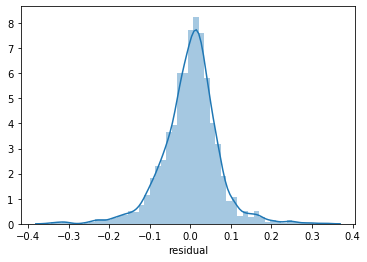

In [132]:
sns.distplot(app_data['residual'])

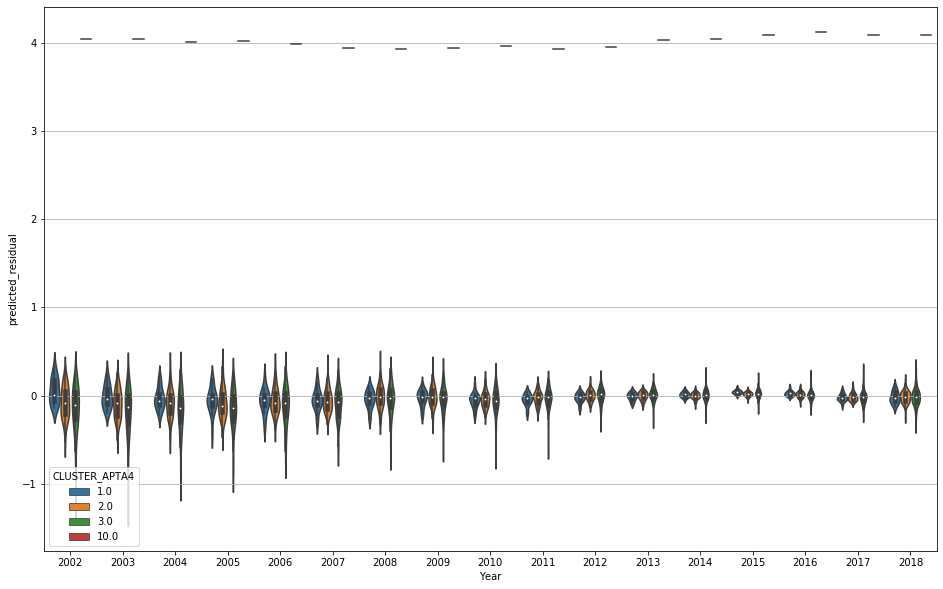

In [133]:
plt.figure(figsize=(16, 10))
plt.grid()
sns.violinplot(x="Year", y="predicted_residual", hue="CLUSTER_APTA4", data=app_data[app_data['RAIL_FLAG']==0])

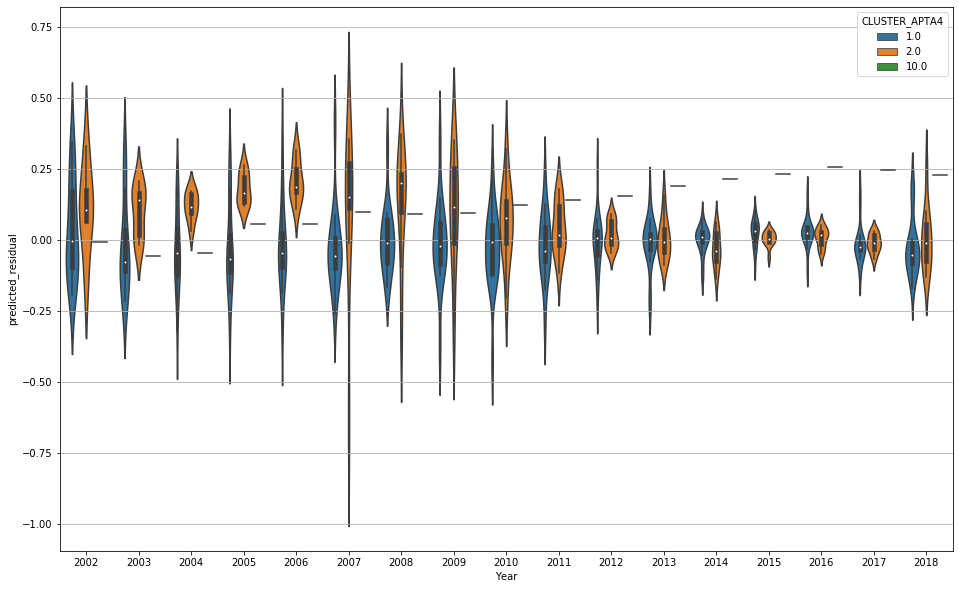

In [134]:
plt.figure(figsize=(16, 10))
plt.grid()
sns.violinplot(x="Year", y="predicted_residual", hue="CLUSTER_APTA4", data=app_data[app_data['RAIL_FLAG']==1])

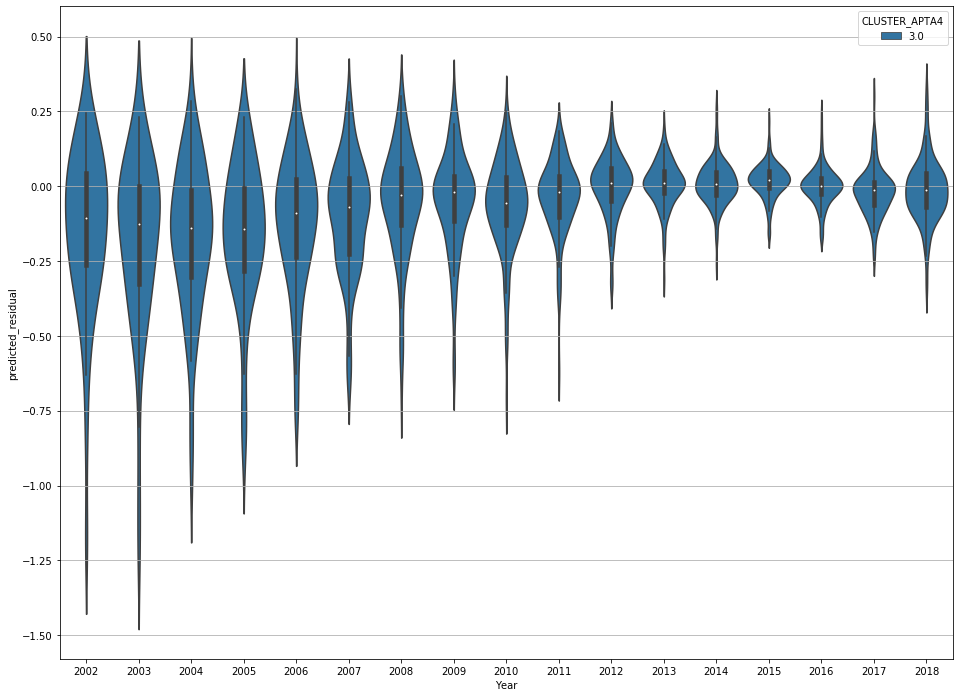

In [135]:
plt.figure(figsize=(16, 12))
plt.grid()
sns.violinplot(x="Year", y="predicted_residual", hue="CLUSTER_APTA4", data=app_data[app_data['CLUSTER_APTA4']==3])

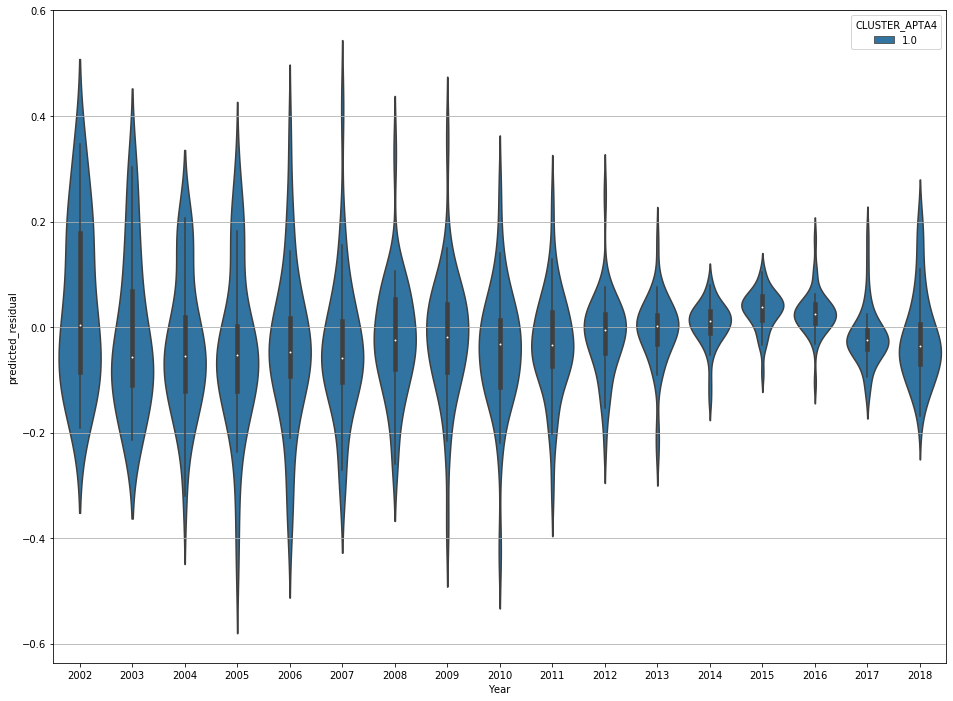

In [136]:
plt.figure(figsize=(16, 12))
plt.grid()
sns.violinplot(x="Year", y="predicted_residual", hue="CLUSTER_APTA4", data=app_data[app_data['CLUSTER_APTA4']==1])

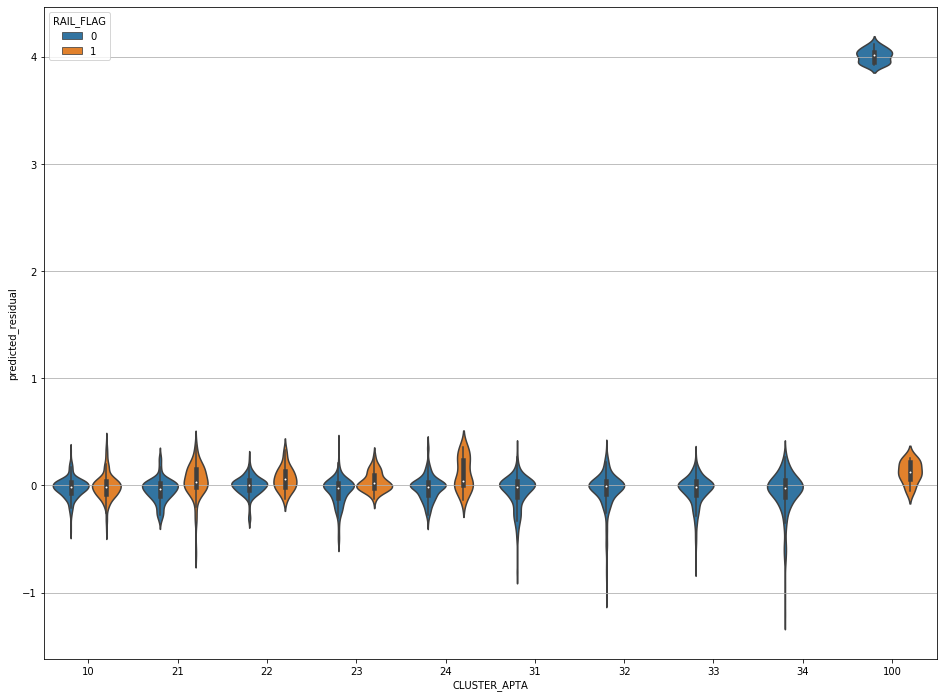

In [137]:
plt.figure(figsize=(16, 12))
plt.grid()
sns.violinplot(x="CLUSTER_APTA", y="predicted_residual", hue="RAIL_FLAG", data=app_data)

In [138]:
app_data['YEARS_SINCE_TNC'] =(app_data['YEARS_SINCE_TNC_BUS_NY'] 
                            + app_data['YEARS_SINCE_TNC_BUS_HI']
                            + app_data['YEARS_SINCE_TNC_BUS_MID']
                            + app_data['YEARS_SINCE_TNC_BUS_LOW']
                            + app_data['YEARS_SINCE_TNC_RAIL_NY']
                            + app_data['YEARS_SINCE_TNC_RAIL_HI']
                            + app_data['YEARS_SINCE_TNC_RAIL_MID']) 
                              

KeyError: 'YEARS_SINCE_TNC_BUS_NY'

In [ ]:
plt.figure(figsize=(16, 12))
plt.grid()
sns.violinplot(x="YEARS_SINCE_TNC", y="predicted_residual", hue="CLUSTER_APTA4", data=app_data[app_data['RAIL_FLAG']==0])


In [ ]:
plt.figure(figsize=(16, 12))
plt.grid()
sns.violinplot(x="YEARS_SINCE_TNC", 
               y="predicted_residual", 
               hue="CLUSTER_APTA4", 
               data=app_data[app_data['RAIL_FLAG']==1])


In [ ]:
df2 = df.reset_index()

In [ ]:
plt.figure(figsize=(16, 10))
plt.grid()
sns.violinplot(x="Year", y="YEARS_SINCE_TNC", hue="CLUSTER_APTA4", data=df2)

In [ ]:
plt.figure(figsize=(16, 10))
plt.grid()
sns.violinplot(x="Year", y="TNC_TRIPS_PER_CAPITA_CLUSTER", hue="CLUSTER_APTA4", data=df2)

In [ ]:
plt.figure(figsize=(16, 10))
plt.grid()
sns.violinplot(x="Year", y="TNC_TRIPS_PER_UPT_2012", hue="CLUSTER_APTA4", data=df2)

In [ ]:
df2 = app_data[['RAIL_FLAG',
               'Unknown_FAC', 
               'VRM_ADJ_log', 
               'VRM_ADJ_ratio', 
               'FARE_per_UPT_cleaned_2018_ratio', 
               'POP_EMP_ratio', 
               'GAS_PRICE_2018_ratio',
               'TOTAL_MED_INC_INDIV_2018_ratio',
               'PCT_HH_NO_VEH_diff',
               'JTW_HOME_PCT_diff'
              ]]
sns.PairGrid(df2, hue="RAIL_FLAG")

In [ ]:
df2 = app_data[['RAIL_FLAG', 
               'Unknown_FAC', 
               'YEARS_SINCE_TNC_BUS_NY_diff', 
               'YEARS_SINCE_TNC_BUS_HI_diff', 
               'YEARS_SINCE_TNC_BUS_MID_diff', 
               'YEARS_SINCE_TNC_BUS_LOW_diff', 
               'YEARS_SINCE_TNC_RAIL_NY_diff',
               'YEARS_SINCE_TNC_RAIL_HI_diff',
               'YEARS_SINCE_TNC_RAIL_MID_diff'
              ]]
sns.PairGrid(df2, hue="RAIL_FLAG")